Epoch 1 | Train 0.3210 | Val 0.2279
Epoch 2 | Train 0.1239 | Val 0.1202
Epoch 3 | Train 0.0821 | Val 0.0905
Epoch 4 | Train 0.0703 | Val 0.0641
Epoch 5 | Train 0.0559 | Val 0.0704
Epoch 6 | Train 0.0461 | Val 0.0761
Epoch 7 | Train 0.0446 | Val 0.0827
Epoch 8 | Train 0.0437 | Val 0.0773
Epoch 9 | Train 0.0403 | Val 0.0471
Epoch 10 | Train 0.0362 | Val 0.0552
Epoch 11 | Train 0.0358 | Val 0.0530
Epoch 12 | Train 0.0346 | Val 0.0727
Epoch 13 | Train 0.0334 | Val 0.0494
Epoch 14 | Train 0.0310 | Val 0.0587
Epoch 15 | Train 0.0306 | Val 0.0438
Epoch 16 | Train 0.0312 | Val 0.0531
Epoch 17 | Train 0.0297 | Val 0.0629
Epoch 18 | Train 0.0285 | Val 0.0608
Epoch 19 | Train 0.0291 | Val 0.0473
Epoch 20 | Train 0.0274 | Val 0.0441
Epoch 21 | Train 0.0263 | Val 0.0556
Epoch 22 | Train 0.0278 | Val 0.0438
Epoch 23 | Train 0.0249 | Val 0.0492
Epoch 24 | Train 0.0272 | Val 0.0491
Epoch 25 | Train 0.0239 | Val 0.0592

=== Transformer TEST RESULTS ===
R²: 0.9029527902603149
RMSE: 190.42578


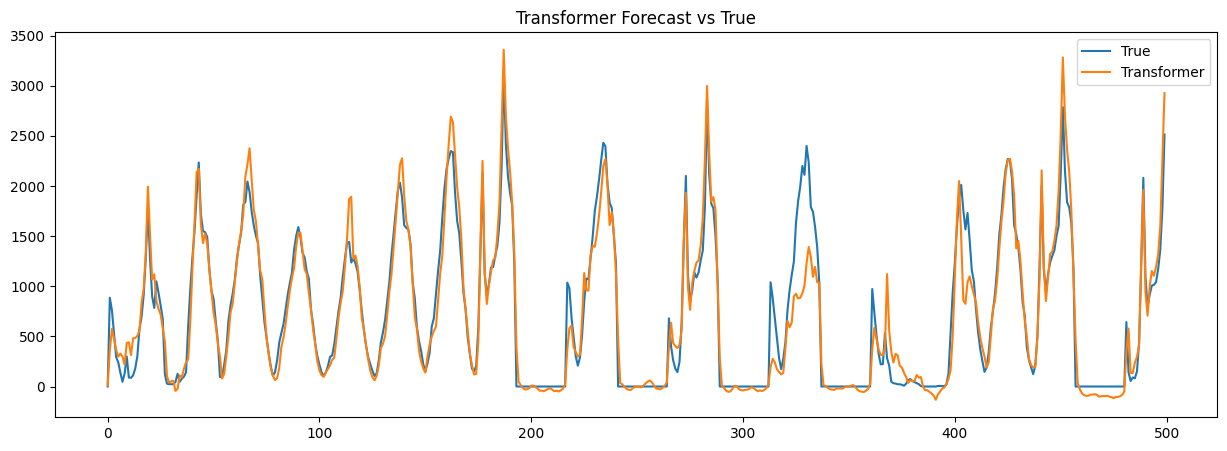

In [1]:
# ============================================================
# A Predictive Analytics Approach for Forecasting Bike Demand
# Transformer implementation (highest R² in paper)
# ============================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# Early stopping helper (REUSED FROM YOUR CODE)
# ============================================================

class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# ============================================================
# 1. Load data (REUSED)
# ============================================================

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ============================================================
# 2. Feature engineering (REUSED)
# ============================================================

def add_engineered_features(df, max_lag=3):
    df = df.copy()

    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - 0.1 * df['Humidity(%)']
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)

# ============================================================
# 3. Feature selection using XGBoost (REUSED)
# ============================================================

feature_cols = [c for c in df.columns if c not in ['Date', target_col]]

X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

xgb = XGBRegressor(random_state=42, n_jobs=-1)
xgb.fit(X, y)

feat_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

selected_features = feat_imp['feature'].iloc[:20].tolist()

# ============================================================
# 4. Train-test split by date (REUSED)
# ============================================================

unique_dates = df['Date'].dt.date.unique()
split_idx = int(len(unique_dates) * 0.8)

train_dates = unique_dates[:split_idx]
test_dates = unique_dates[split_idx:]

train_df = df[df['Date'].dt.date.isin(train_dates)]
test_df = df[df['Date'].dt.date.isin(test_dates)]

X_train = train_df[selected_features].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[selected_features].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ============================================================
# 5. Scaling (REUSED)
# ============================================================

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ============================================================
# 6. Sequence creation (REUSED)
# ============================================================

def create_sequences(X, y, seq_len=24):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i + seq_len])
        ys.append(y[i + seq_len - 1])
    return np.array(Xs), np.array(ys)


SEQ_LEN = 24
X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, SEQ_LEN)

# Train/val split
val_size = int(len(X_train_seq) * 0.15)

X_tr, X_val = X_train_seq[:-val_size], X_train_seq[-val_size:]
y_tr, y_val = y_train_seq[:-val_size], y_train_seq[-val_size:]

# ============================================================
# 7. DataLoaders (REUSED)
# ============================================================

batch_size = 32

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_tr), torch.tensor(y_tr).unsqueeze(1)),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(torch.tensor(X_val), torch.tensor(y_val).unsqueeze(1)),
    batch_size=batch_size
)

test_loader = DataLoader(
    TensorDataset(torch.tensor(X_test_seq), torch.tensor(y_test_seq).unsqueeze(1)),
    batch_size=batch_size
)

# ============================================================
# 8. Transformer model (FROM PAPER)
# ============================================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div)
        pe[:, 1::2] = torch.cos(position * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TransformerRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.proj = nn.Linear(input_dim, 128)
        self.pos_enc = PositionalEncoding(128)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            dim_feedforward=256,
            dropout=0.2,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.fc(x)

# ============================================================
# 9. Training (REUSED)
# ============================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRegressor(X_train_seq.shape[2]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
early_stopper = EarlyStopper()

for epoch in range(100):
    model.train()
    losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1} | Train {np.mean(losses):.4f} | Val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        break

# ============================================================
# 10. Evaluation (REUSED)
# ============================================================

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb.to(device))
        y_true.append(yb.numpy())
        y_pred.append(preds.cpu().numpy())

y_true = scaler_y.inverse_transform(np.vstack(y_true))
y_pred = scaler_y.inverse_transform(np.vstack(y_pred))

print("\n=== Transformer TEST RESULTS ===")
print("R²:", r2_score(y_true, y_pred))
print("RMSE:", np.sqrt(np.mean((y_true - y_pred) ** 2)))

# ============================================================
# 11. Plot
# ============================================================

plt.figure(figsize=(15, 5))
plt.plot(y_true[:500], label='True')
plt.plot(y_pred[:500], label='Transformer')
plt.legend()
plt.title("Transformer Forecast vs True")
plt.show()


trail 2

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

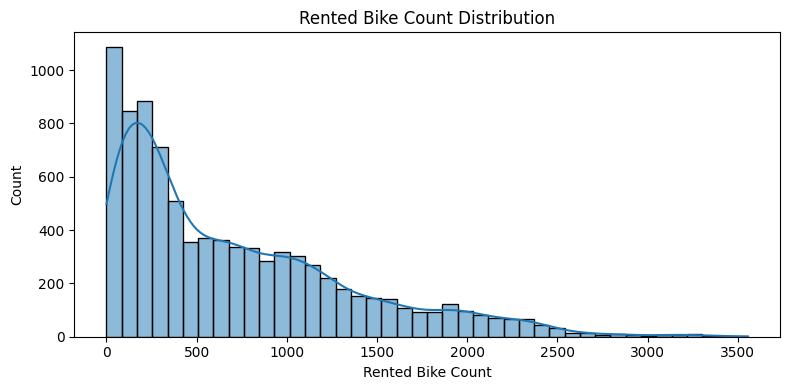

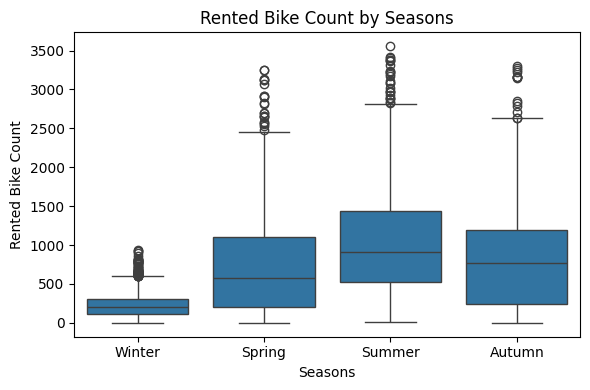

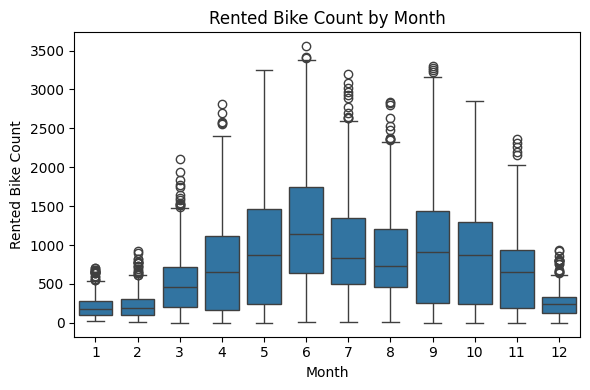

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\2339739602.py:86: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


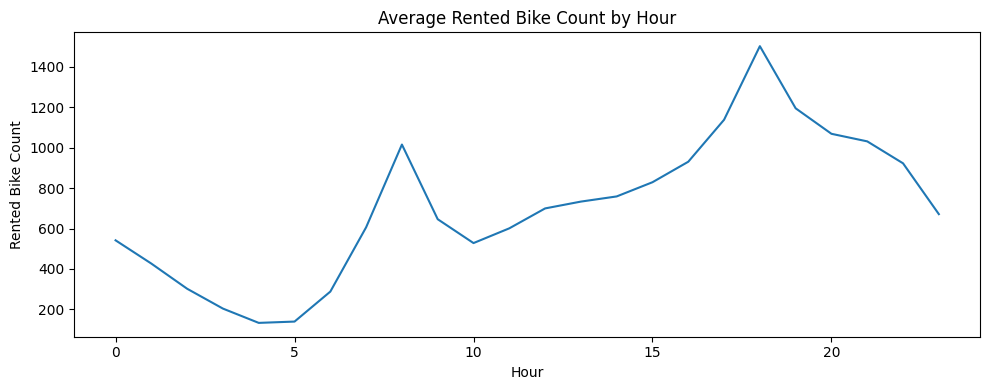

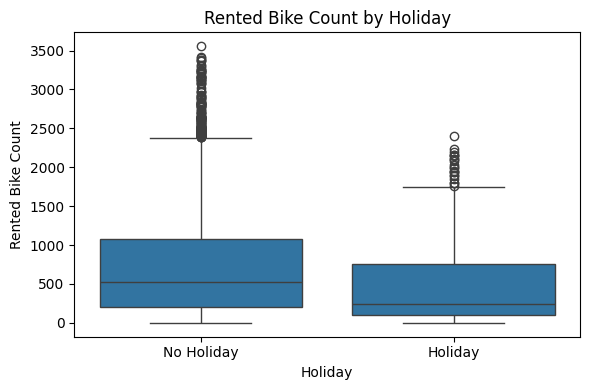

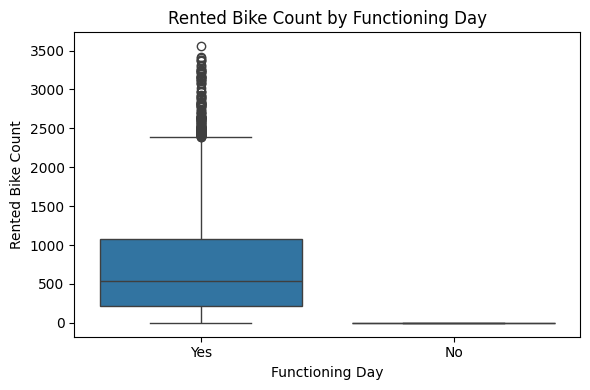

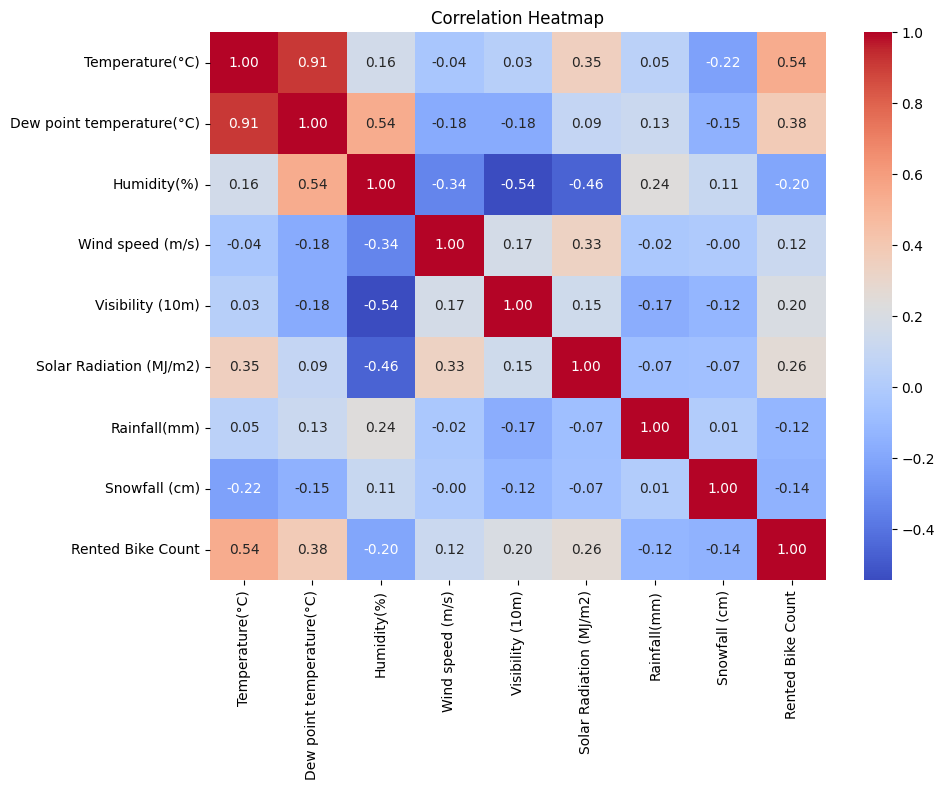

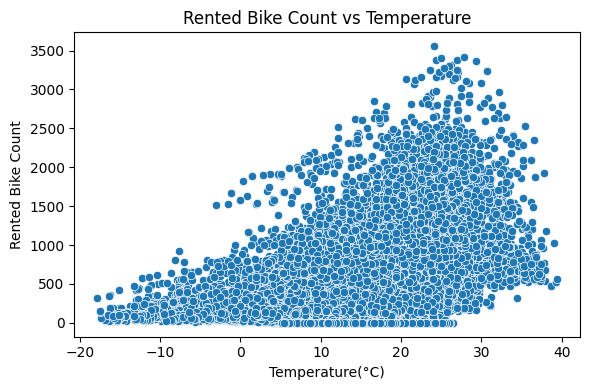

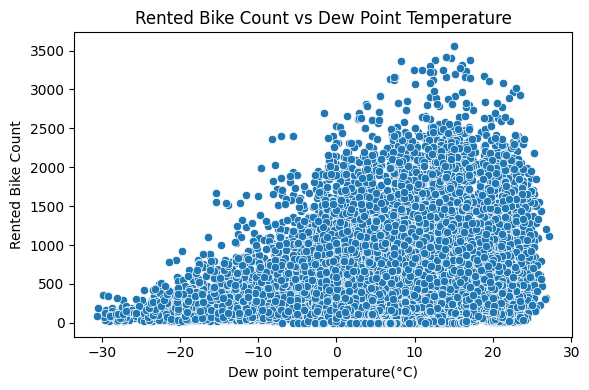

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\2339739602.py:134: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


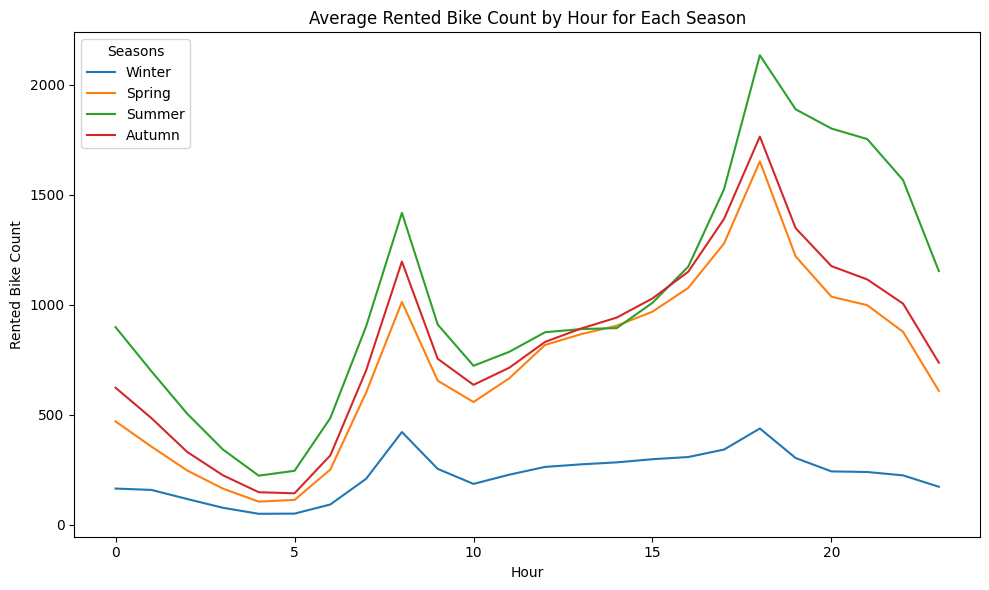

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TransformerRegressor: input 20 feats -> d_model=64, heads=4, layers=2
TemporalCNN (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.1889 | val 0.1215
Epoch 2/100: train 0.0908 | val 0.1144
Epoch 3/100: train 0.0675 | val 0.0866
Epoch 4/100: train 0.0575 | val 0.0789
Epoch 5/100: train 0.0545 | val 0.0678
Epoch 6/100: train 0.0474 | val 0.0566
Epoch 7/100: train 0.0452 | val 0.0548
Epoch 8/100: train 0.0437 | val 0.0600
Epoch 9/100: train 0.0409 | val 0.0425
Epoch 10/100: train 0.0393 | val 0.0612
Epoch 11/100: train 0.0379 | val 0.0460
Epoch 12/100: train 0.0382 | val 0.0451
Epoch 13/100: train 0.0401 | val 0.0539
Epoch 14/100: train 0.0360 | val 0.0567
Epoch 15/100: train 0.0367 | val 0.0548
Epoch 16/100: train 0.0362 | val 0.0542
Epoch 17/100: train 0.0357 | val 0.0430
Epoch 18/100: train 0.0360 | val 0.0455
Epoch 19/100: train 0.0327 | val 0.0582
Early stopping at epoch

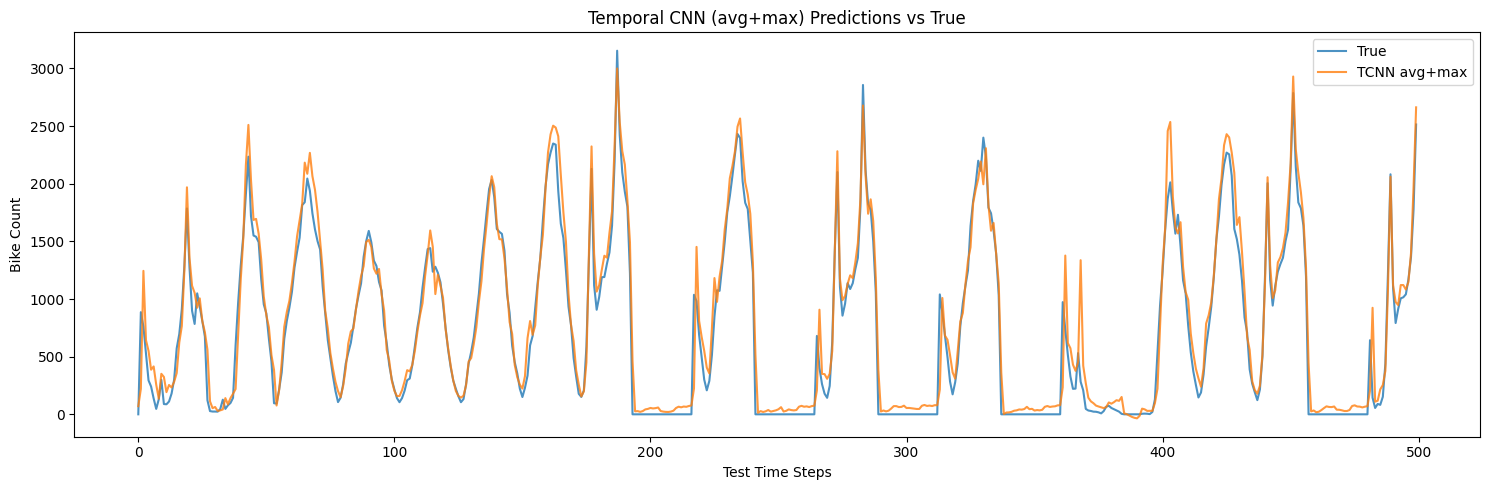

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning like PPT: convert Date to datetime, etc.[file:1]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (similar to PPT) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots[file:1]
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables[file:1]
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# # ---------------- 8. Temporal CNN model ----------------
# class TemporalCNN(nn.Module):
#     def __init__(self, input_size, channels=80, dropout=0.3):
#         super().__init__()
#         self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm1d(channels)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(2 * channels, 1)

#     def forward(self, x):
#         # x: [B, T, F]
#         x = x.transpose(1, 2)           # [B, F, T]
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = torch.relu(self.conv3(x))
#         x = self.bn(x)
#         x = torch.relu(x)               # [B, C, T]

#         avg_pool = x.mean(dim=2)        # [B, C]
#         max_pool, _ = x.max(dim=2)      # [B, C]
#         feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

#         feats = self.dropout(feats)
#         return self.fc(feats)           # [B, 1]


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
# print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
# criterion = nn.MSELoss()
# epochs = 100
# early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # [T, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        x = x + self.pe[:, :T, :]
        return x


class TransformerRegressor(nn.Module):
    def __init__(
        self,
        input_size,          # n_features
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.2
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = self.input_proj(x)          # [B, T, d_model]
        x = self.pos_encoder(x)         # [B, T, d_model]
        x = self.encoder(x)             # [B, T, d_model]
        last = x[:, -1, :]              # [B, d_model]
        out = self.fc_out(last)         # [B, 1]
        return out
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRegressor(
    input_size=n_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.2
).to(device)

print(f"TransformerRegressor: input {n_features} feats -> d_model=64, heads=4, layers=2")

print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Evaluation on TRAIN set ----------------
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# ---------------- 11. Evaluation on TEST set ----------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 12. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()



Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

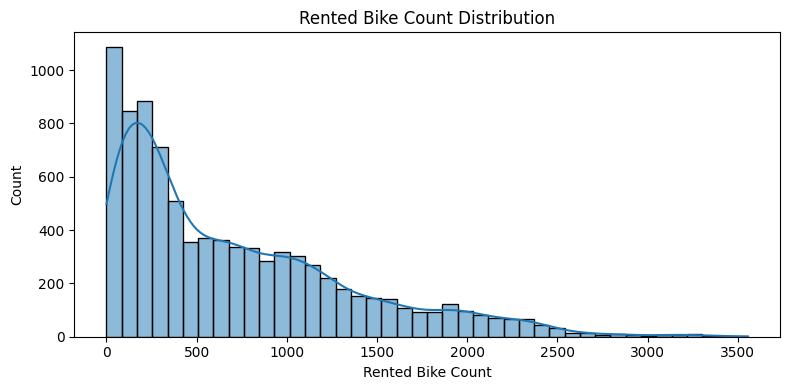

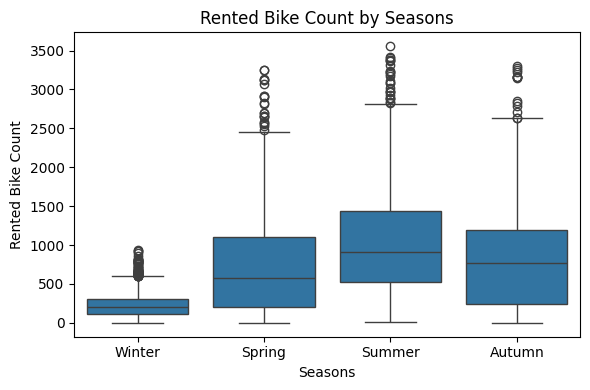

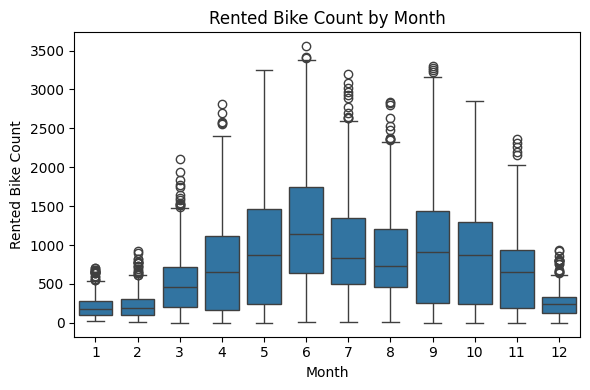

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\2339739602.py:86: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


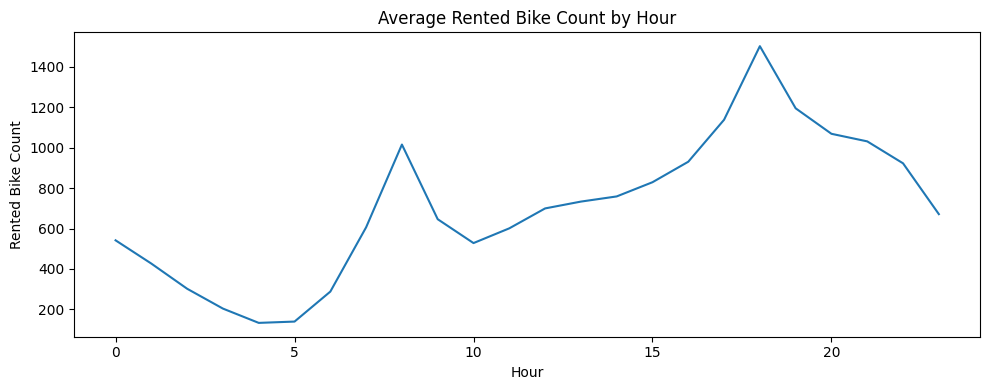

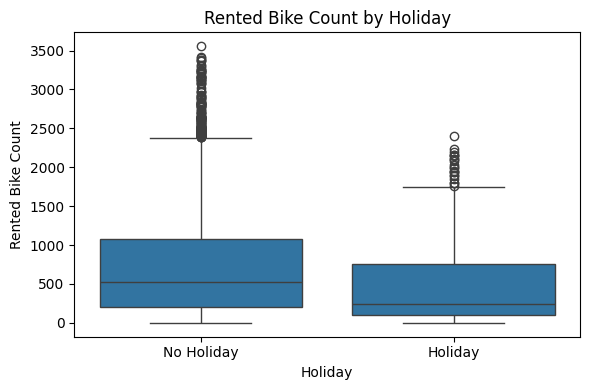

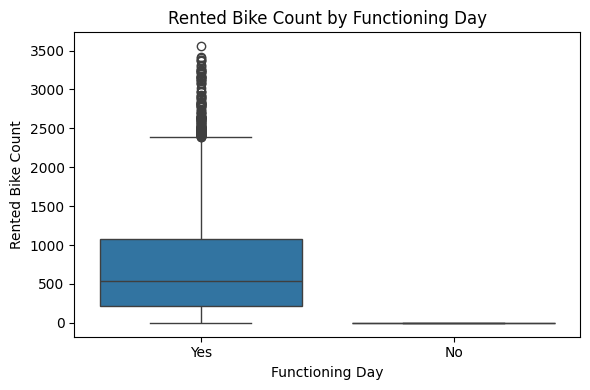

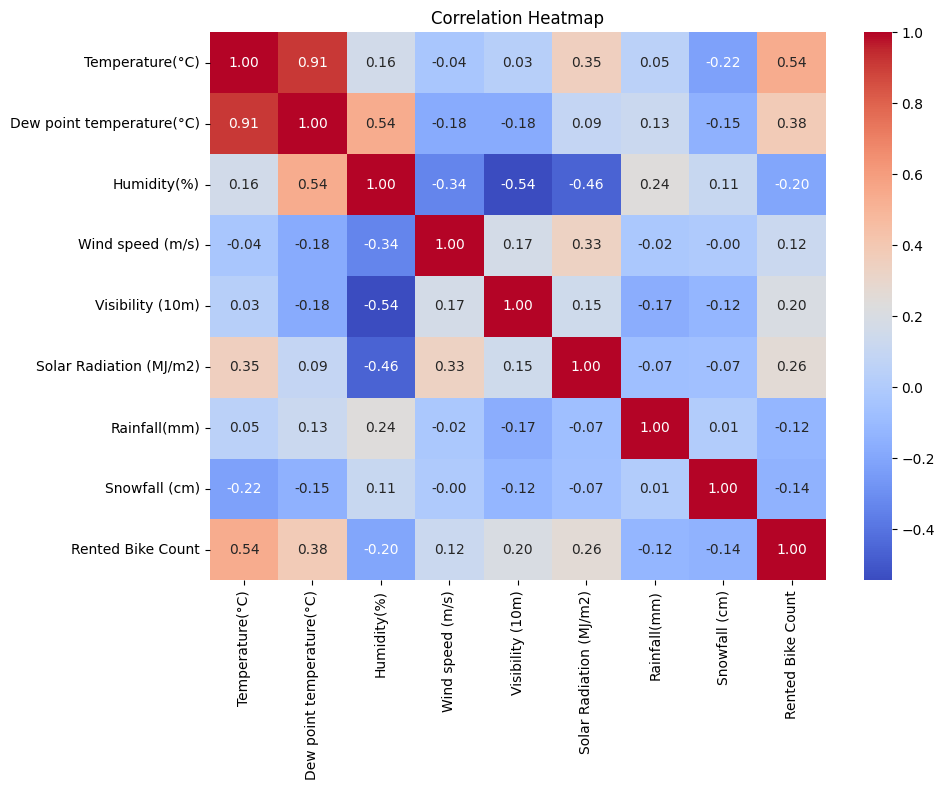

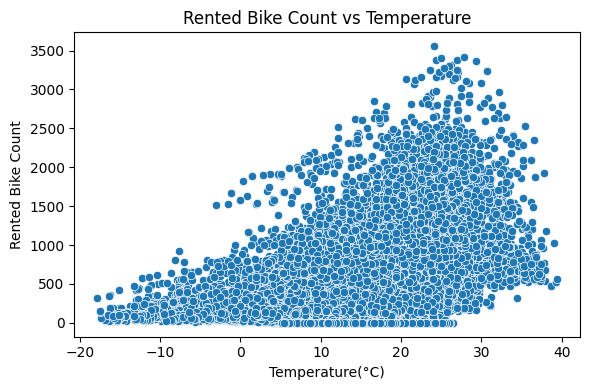

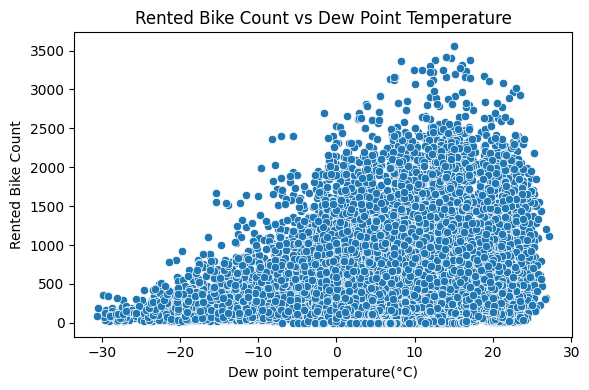

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\2339739602.py:134: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


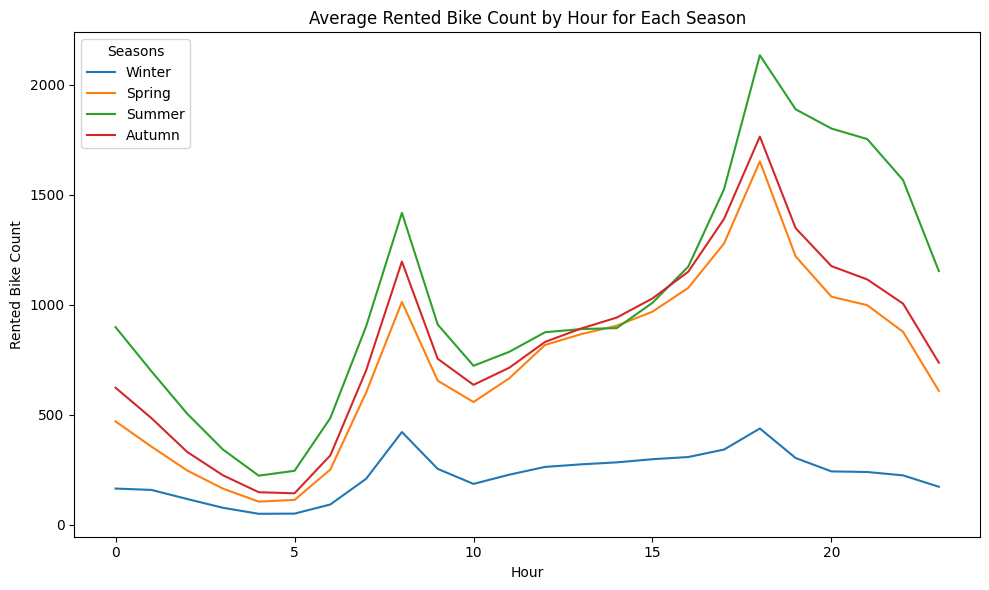

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TransformerRegressor: input 20 feats -> d_model=64, heads=4, layers=2
TemporalCNN (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.1788 | val 0.2209
Epoch 2/100: train 0.0858 | val 0.0813
Epoch 3/100: train 0.0729 | val 0.0860
Epoch 4/100: train 0.0568 | val 0.0632
Epoch 5/100: train 0.0483 | val 0.0679
Epoch 6/100: train 0.0518 | val 0.0646
Epoch 7/100: train 0.0469 | val 0.0631
Epoch 8/100: train 0.0412 | val 0.0588
Epoch 9/100: train 0.0433 | val 0.0526
Epoch 10/100: train 0.0391 | val 0.0458
Epoch 11/100: train 0.0390 | val 0.0495
Epoch 12/100: train 0.0390 | val 0.0425
Epoch 13/100: train 0.0377 | val 0.0521
Epoch 14/100: train 0.0373 | val 0.0555
Epoch 15/100: train 0.0382 | val 0.0574
Epoch 16/100: train 0.0350 | val 0.0629
Epoch 17/100: train 0.0377 | val 0.0413
Epoch 18/100: train 0.0395 | val 0.0460
Epoch 19/100: train 0.0375 | val 0.0453
Epoch 20/100: train 0.0

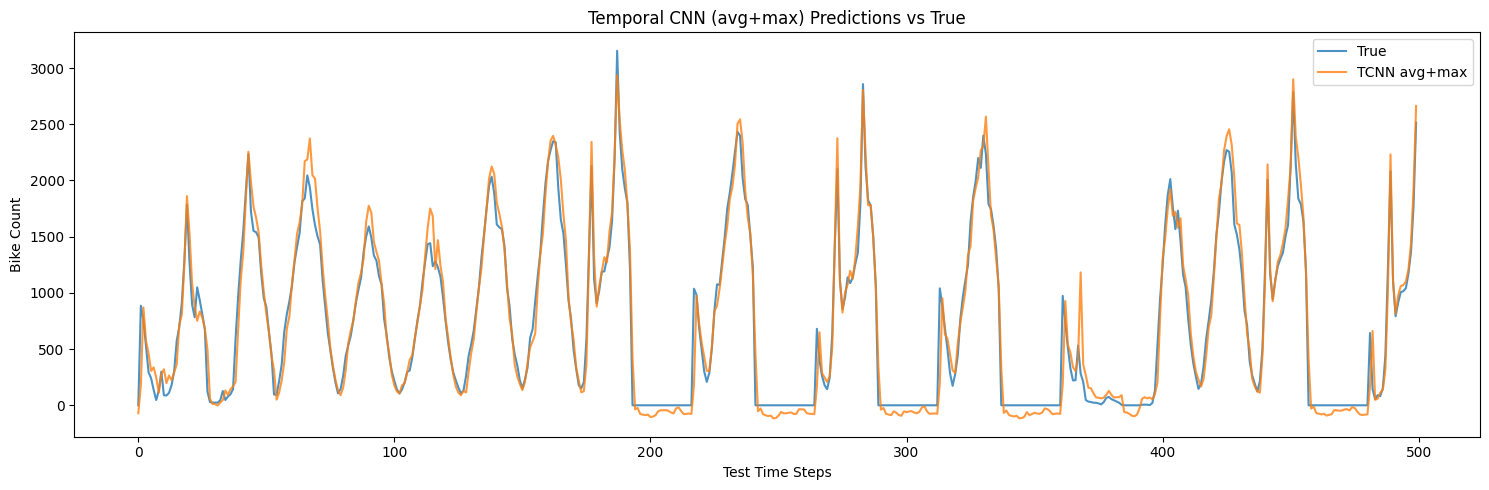

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning like PPT: convert Date to datetime, etc.[file:1]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (similar to PPT) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots[file:1]
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables[file:1]
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# # ---------------- 8. Temporal CNN model ----------------
# class TemporalCNN(nn.Module):
#     def __init__(self, input_size, channels=80, dropout=0.3):
#         super().__init__()
#         self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm1d(channels)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(2 * channels, 1)

#     def forward(self, x):
#         # x: [B, T, F]
#         x = x.transpose(1, 2)           # [B, F, T]
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = torch.relu(self.conv3(x))
#         x = self.bn(x)
#         x = torch.relu(x)               # [B, C, T]

#         avg_pool = x.mean(dim=2)        # [B, C]
#         max_pool, _ = x.max(dim=2)      # [B, C]
#         feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

#         feats = self.dropout(feats)
#         return self.fc(feats)           # [B, 1]


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
# print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
# criterion = nn.MSELoss()
# epochs = 100
# early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # [T, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        x = x + self.pe[:, :T, :]
        return x


class TransformerRegressor(nn.Module):
    def __init__(
        self,
        input_size,          # n_features
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.2
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = self.input_proj(x)          # [B, T, d_model]
        x = self.pos_encoder(x)         # [B, T, d_model]
        x = self.encoder(x)             # [B, T, d_model]
        last = x[:, -1, :]              # [B, d_model]
        out = self.fc_out(last)         # [B, 1]
        return out
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRegressor(
    input_size=n_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.2
).to(device)

print(f"TransformerRegressor: input {n_features} feats -> d_model=64, heads=4, layers=2")

print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Evaluation on TRAIN set ----------------
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# ---------------- 11. Evaluation on TEST set ----------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 12. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()



trying it with top 25 features

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

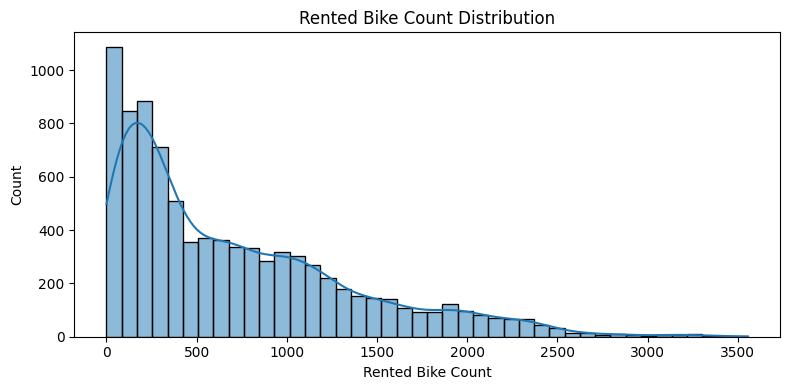

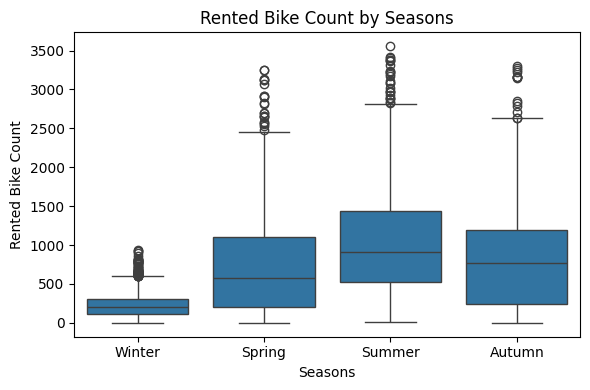

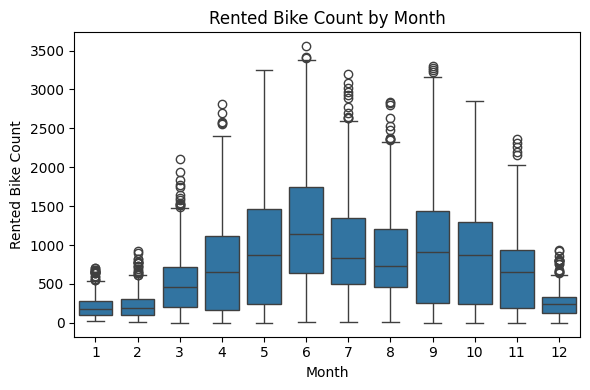

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\1669421298.py:86: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


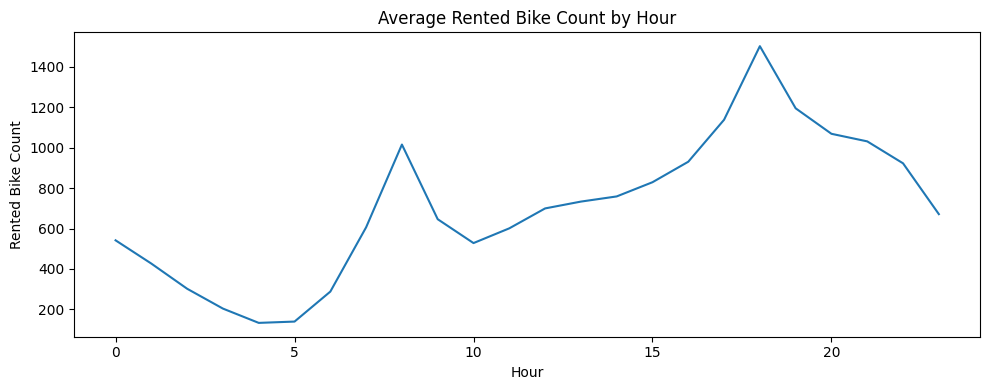

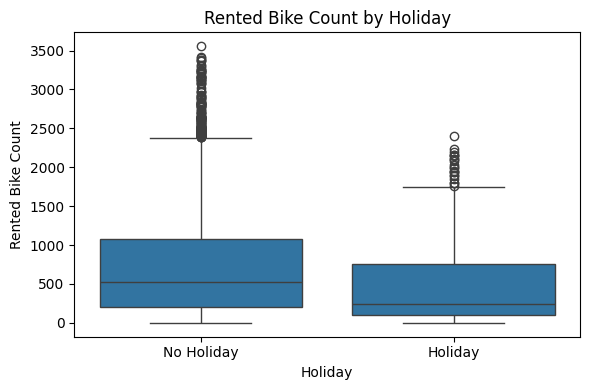

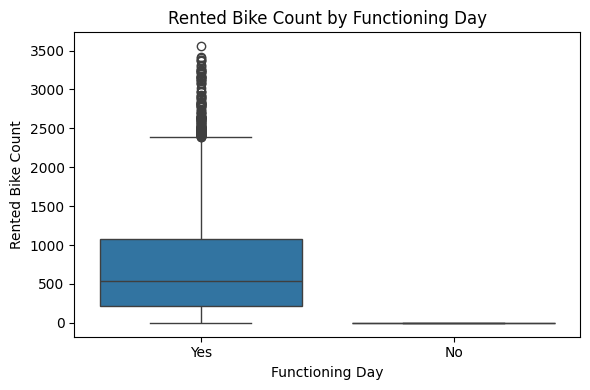

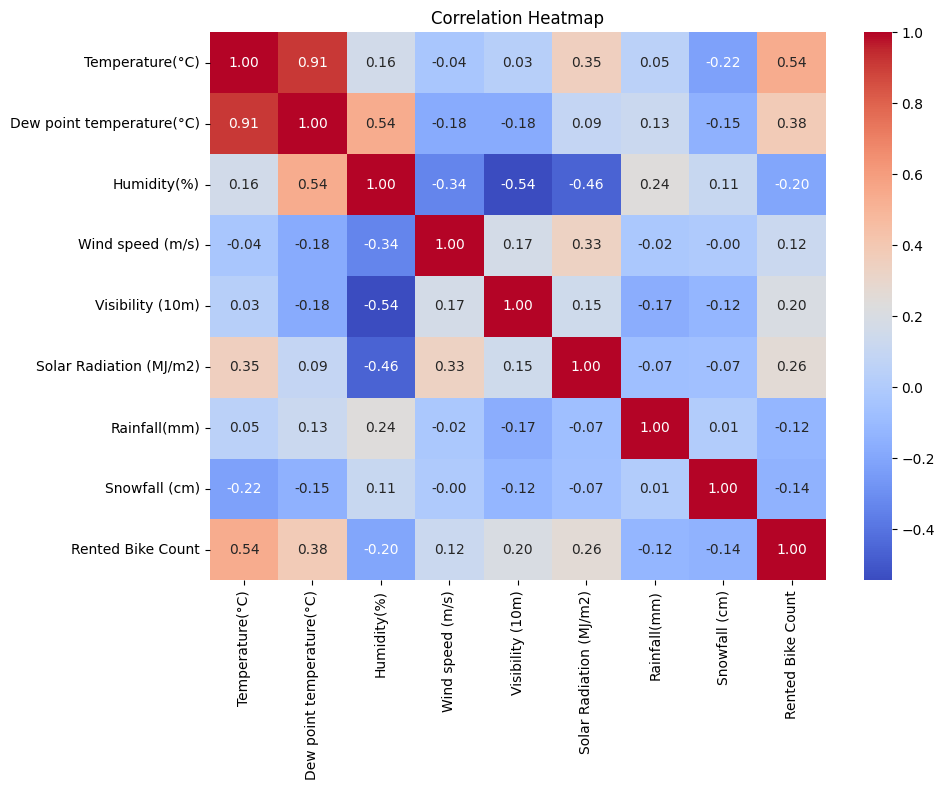

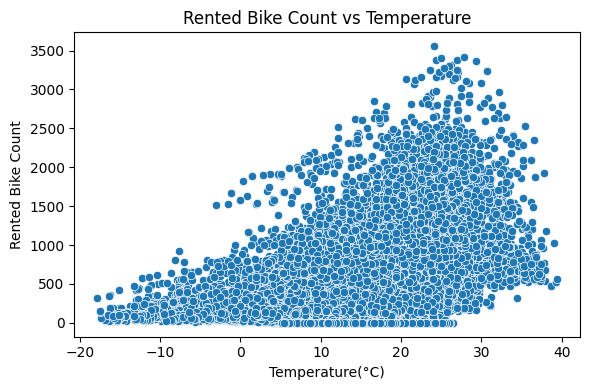

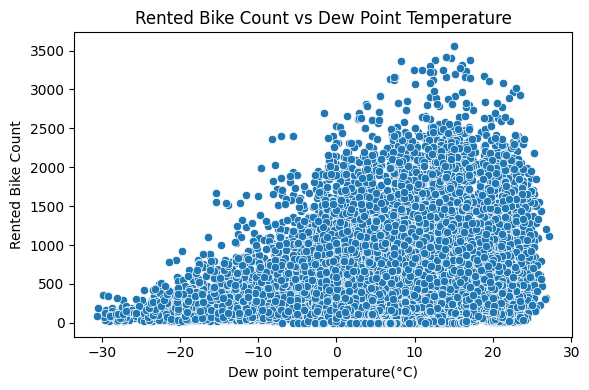

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\1669421298.py:134: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


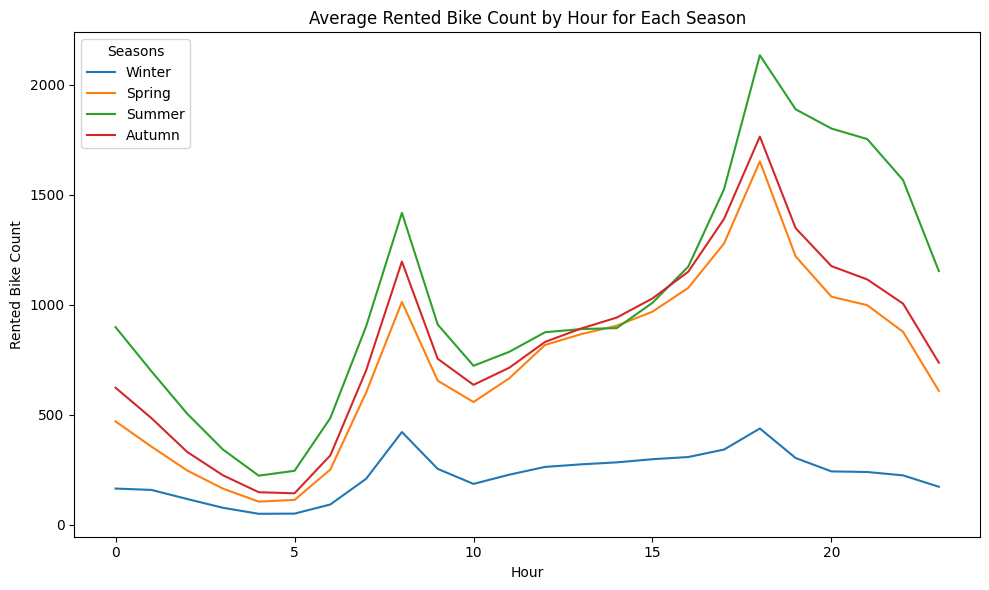

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 25), features: 25
TransformerRegressor: input 25 feats -> d_model=64, heads=4, layers=2
Epoch 1/100: train 0.1908 | val 0.1369
Epoch 2/100: train 0.0885 | val 0.0751
Epoch 3/100: train 0.0717 | val 0.0709
Epoch 4/100: train 0.0627 | val 0.0774
Epoch 5/100: train 0.0573 | val 0.0573
Epoch 6/100: train 0.0508 | val 0.0579
Epoch 7/100: train 0.0451 | val 0.0539
Epoch 8/100: train 0.0432 | val 0.0480
Epoch 9/100: train 0.0451 | val 0.0509
Epoch 10/100: train 0.0396 | val 0.0767
Epoch 11/100: train 0.0460 | val 0.0470
Epoch 12/100: train 0.0408 | val 0.0511
Epoch 13/100: train 0.0439 | val 0.0563
Epoch 14/100: train 0.0397 | val 0.0603
Epoch 15/100: train 0.0358 | val 0.0472
Epoch 16/100: train 0.0349 | val 0.0482
Epoch 17/100: train 0.0355 | val 0.0464
Epoch 18/100: train 0.0334 | val 0.0741
Epoch 19/100: train 0.0361 | val 0.0446
Epoch 20/100: train 0.0328 | val 0.0563
Epoch 21/100: train 0.0326 | val 0.0451
E

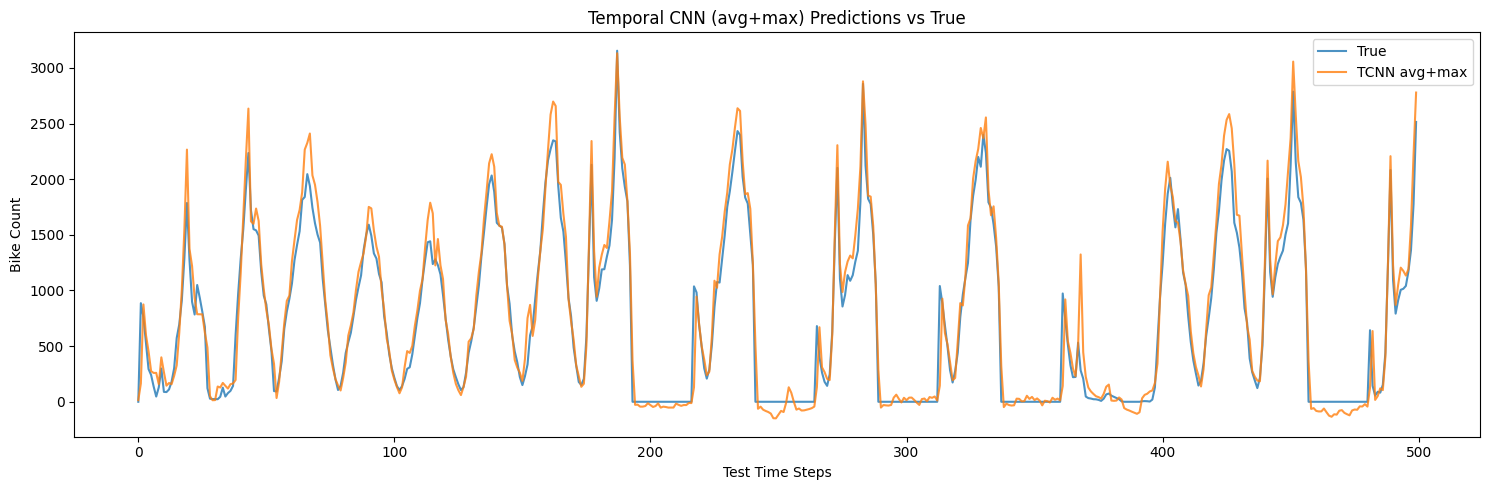

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning like PPT: convert Date to datetime, etc.[file:1]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (similar to PPT) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots[file:1]
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables[file:1]
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 25
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# # ---------------- 8. Temporal CNN model ----------------
# class TemporalCNN(nn.Module):
#     def __init__(self, input_size, channels=80, dropout=0.3):
#         super().__init__()
#         self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm1d(channels)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(2 * channels, 1)

#     def forward(self, x):
#         # x: [B, T, F]
#         x = x.transpose(1, 2)           # [B, F, T]
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = torch.relu(self.conv3(x))
#         x = self.bn(x)
#         x = torch.relu(x)               # [B, C, T]

#         avg_pool = x.mean(dim=2)        # [B, C]
#         max_pool, _ = x.max(dim=2)      # [B, C]
#         feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

#         feats = self.dropout(feats)
#         return self.fc(feats)           # [B, 1]


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
# print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
# criterion = nn.MSELoss()
# epochs = 100
# early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # [T, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        x = x + self.pe[:, :T, :]
        return x


class TransformerRegressor(nn.Module):
    def __init__(
        self,
        input_size,          # n_features
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.2
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = self.input_proj(x)          # [B, T, d_model]
        x = self.pos_encoder(x)         # [B, T, d_model]
        x = self.encoder(x)             # [B, T, d_model]
        last = x[:, -1, :]              # [B, d_model]
        out = self.fc_out(last)         # [B, 1]
        return out
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRegressor(
    input_size=n_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.2
).to(device)

print(f"TransformerRegressor: input {n_features} feats -> d_model=64, heads=4, layers=2")


optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Evaluation on TRAIN set ----------------
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# ---------------- 11. Evaluation on TEST set ----------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 12. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()



30 features

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

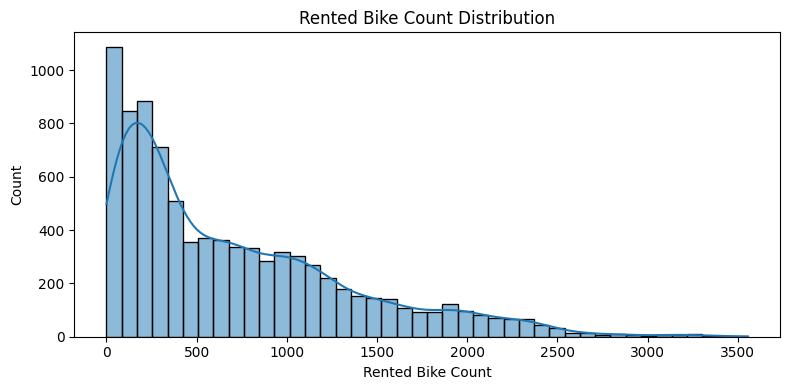

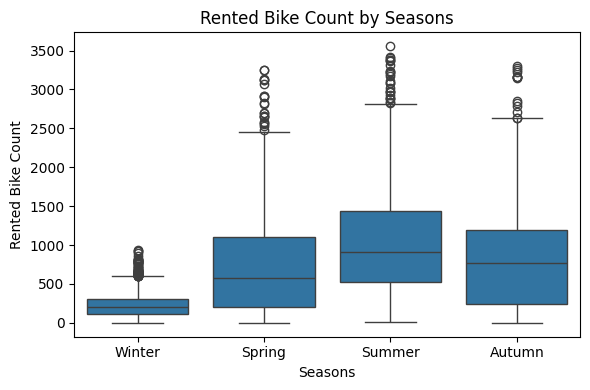

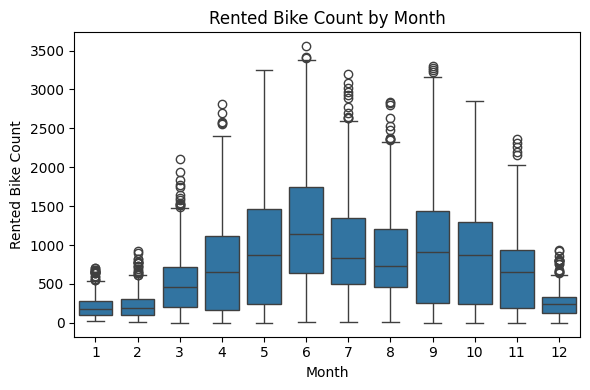

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\2988589594.py:86: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


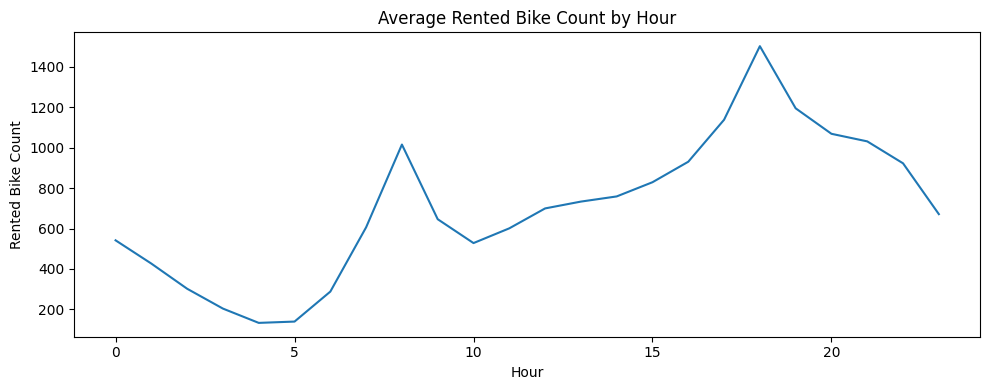

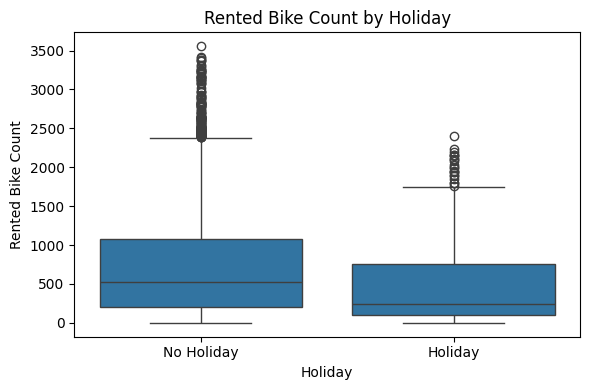

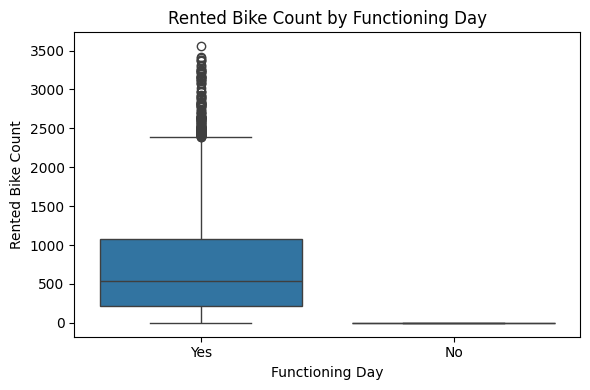

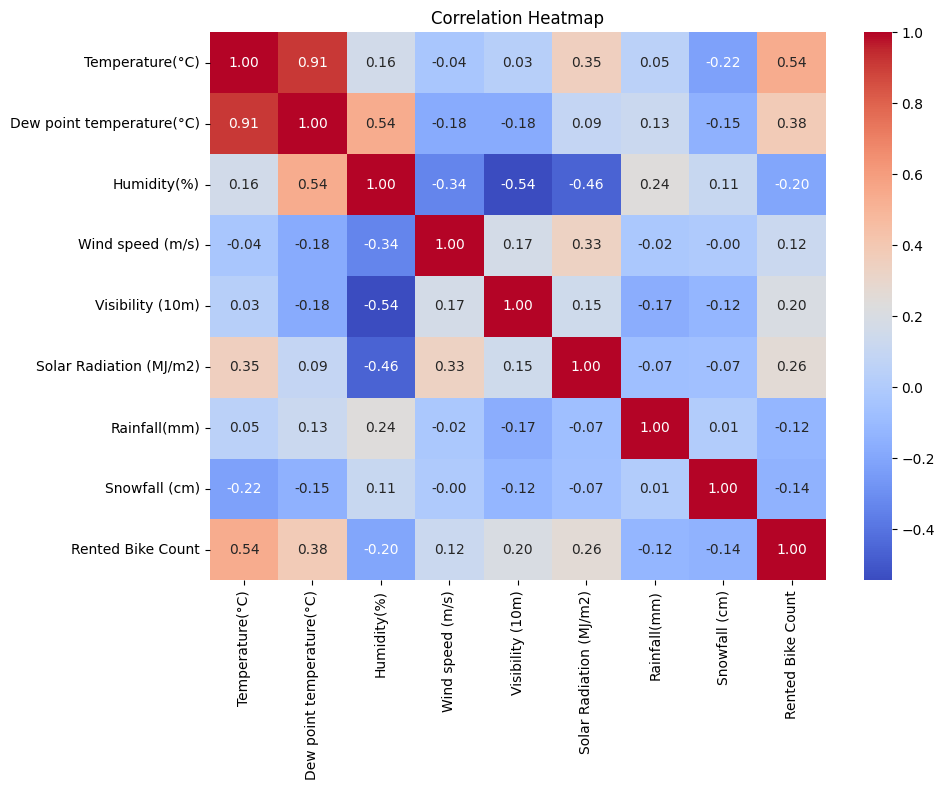

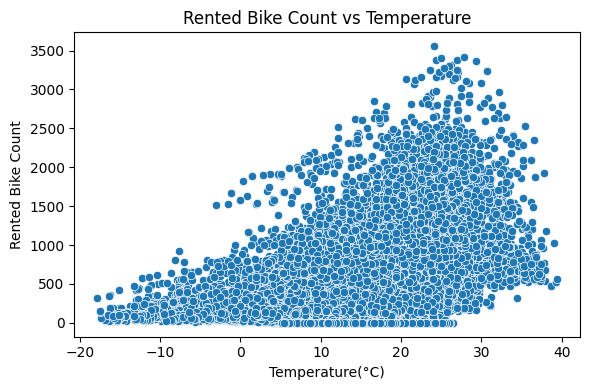

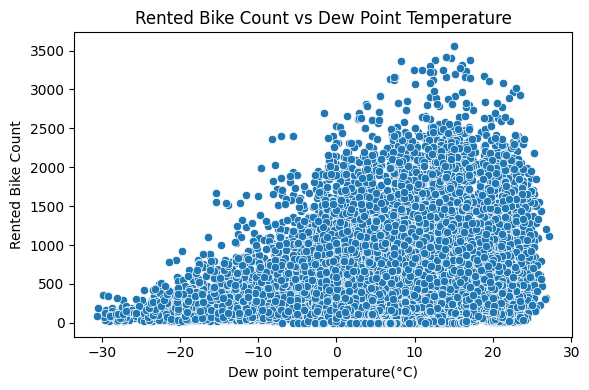

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\2988589594.py:134: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


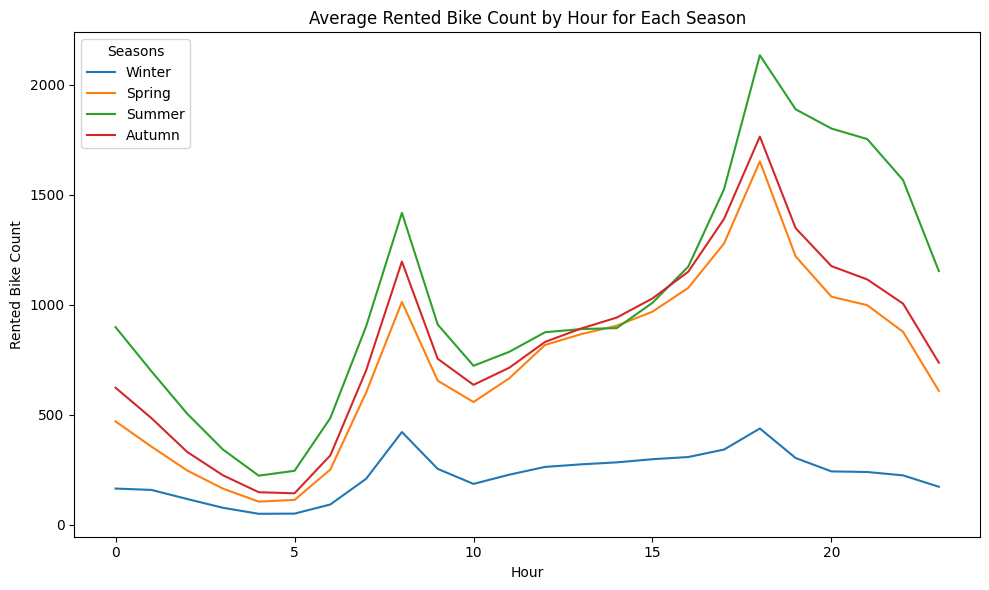

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 30), features: 30
TransformerRegressor: input 30 feats -> d_model=64, heads=4, layers=2
Epoch 1/100: train 0.1867 | val 0.1194
Epoch 2/100: train 0.0975 | val 0.0833
Epoch 3/100: train 0.0730 | val 0.0881
Epoch 4/100: train 0.0636 | val 0.0853
Epoch 5/100: train 0.0587 | val 0.0684
Epoch 6/100: train 0.0477 | val 0.0749
Epoch 7/100: train 0.0436 | val 0.0591
Epoch 8/100: train 0.0431 | val 0.0511
Epoch 9/100: train 0.0424 | val 0.0713
Epoch 10/100: train 0.0446 | val 0.0492
Epoch 11/100: train 0.0377 | val 0.0508
Epoch 12/100: train 0.0361 | val 0.0401
Epoch 13/100: train 0.0367 | val 0.0490
Epoch 14/100: train 0.0385 | val 0.0483
Epoch 15/100: train 0.0390 | val 0.0580
Epoch 16/100: train 0.0361 | val 0.0622
Epoch 17/100: train 0.0357 | val 0.0456
Epoch 18/100: train 0.0324 | val 0.0572
Epoch 19/100: train 0.0344 | val 0.0477
Epoch 20/100: train 0.0330 | val 0.0463
Epoch 21/100: train 0.0353 | val 0.0656
E

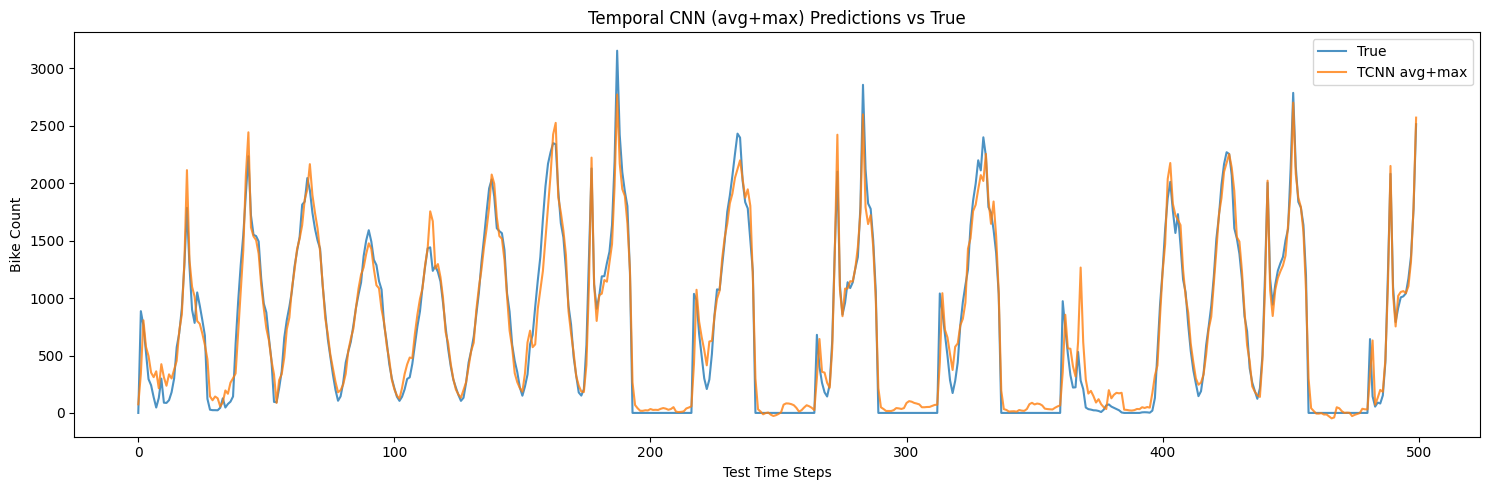

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning like PPT: convert Date to datetime, etc.[file:1]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (similar to PPT) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots[file:1]
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables[file:1]
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# # ---------------- 8. Temporal CNN model ----------------
# class TemporalCNN(nn.Module):
#     def __init__(self, input_size, channels=80, dropout=0.3):
#         super().__init__()
#         self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm1d(channels)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(2 * channels, 1)

#     def forward(self, x):
#         # x: [B, T, F]
#         x = x.transpose(1, 2)           # [B, F, T]
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = torch.relu(self.conv3(x))
#         x = self.bn(x)
#         x = torch.relu(x)               # [B, C, T]

#         avg_pool = x.mean(dim=2)        # [B, C]
#         max_pool, _ = x.max(dim=2)      # [B, C]
#         feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

#         feats = self.dropout(feats)
#         return self.fc(feats)           # [B, 1]


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
# print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
# criterion = nn.MSELoss()
# epochs = 100
# early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # [T, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        x = x + self.pe[:, :T, :]
        return x


class TransformerRegressor(nn.Module):
    def __init__(
        self,
        input_size,          # n_features
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.2
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = self.input_proj(x)          # [B, T, d_model]
        x = self.pos_encoder(x)         # [B, T, d_model]
        x = self.encoder(x)             # [B, T, d_model]
        last = x[:, -1, :]              # [B, d_model]
        out = self.fc_out(last)         # [B, 1]
        return out
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRegressor(
    input_size=n_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.2
).to(device)

print(f"TransformerRegressor: input {n_features} feats -> d_model=64, heads=4, layers=2")


optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Evaluation on TRAIN set ----------------
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# ---------------- 11. Evaluation on TEST set ----------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 12. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()



adding TCNN to the above code architecture

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

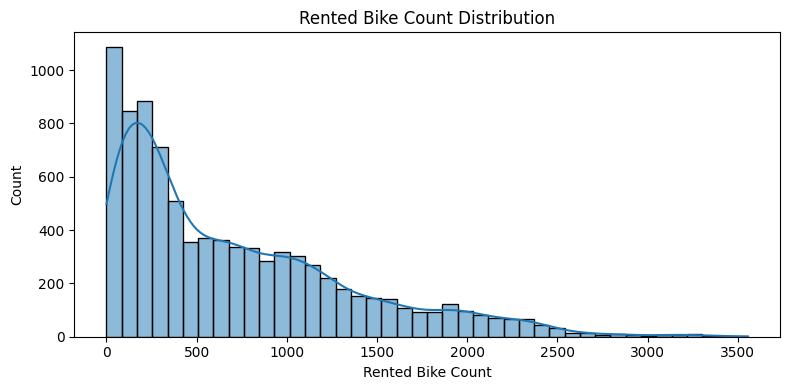

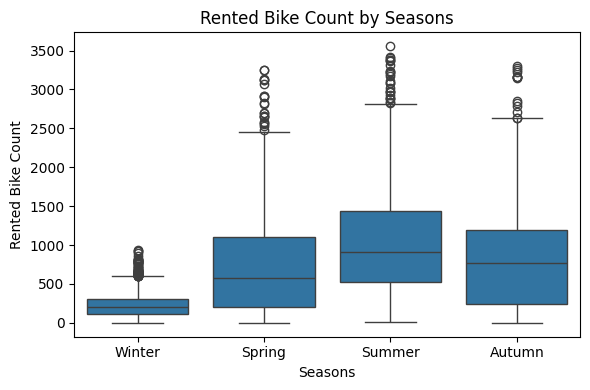

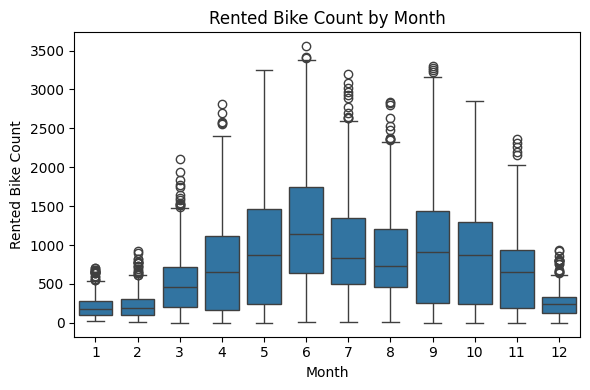

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\1022067043.py:87: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


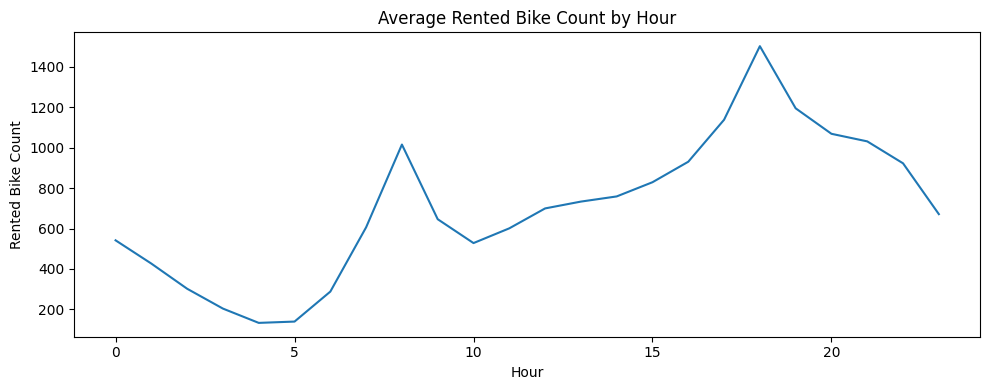

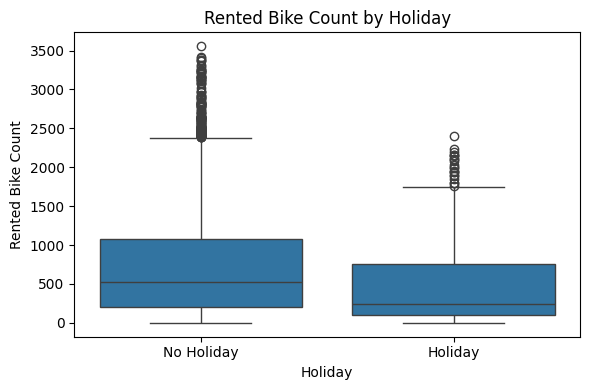

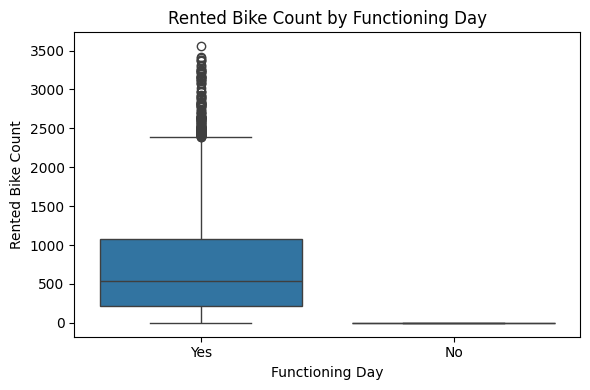

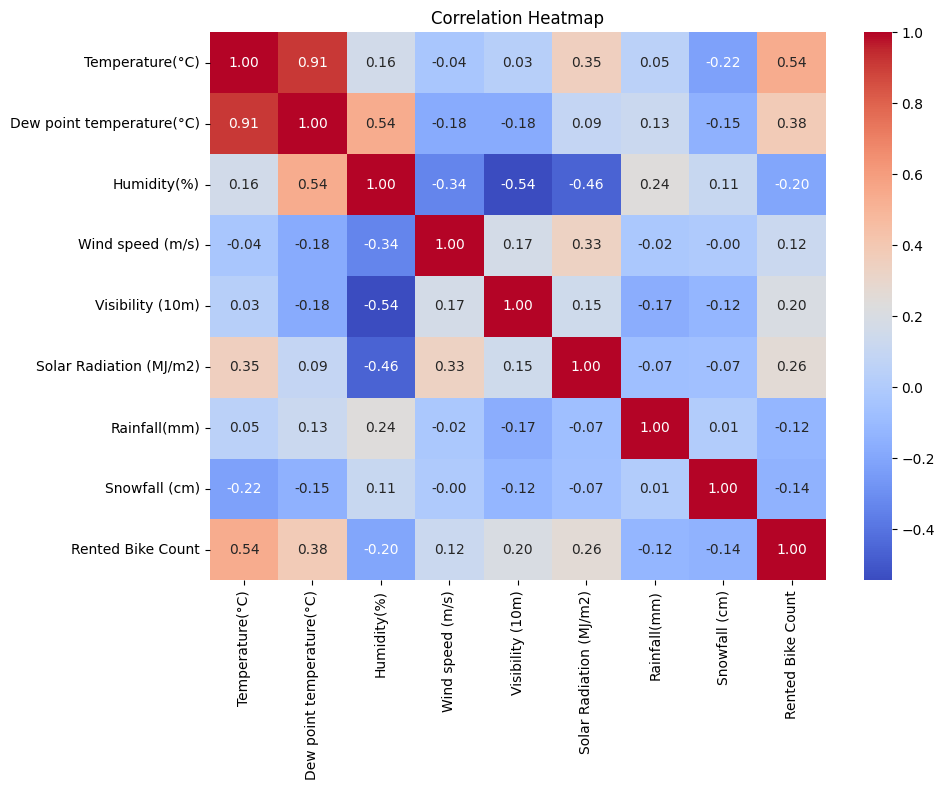

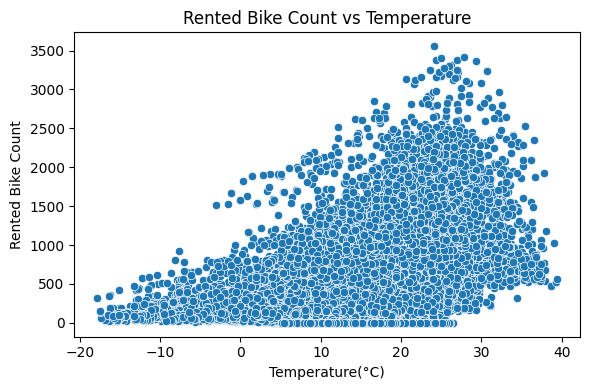

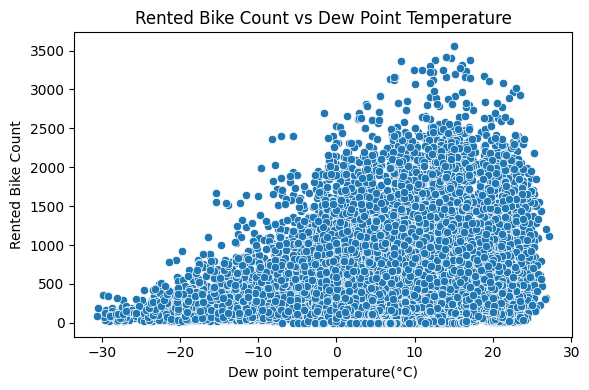

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\1022067043.py:135: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


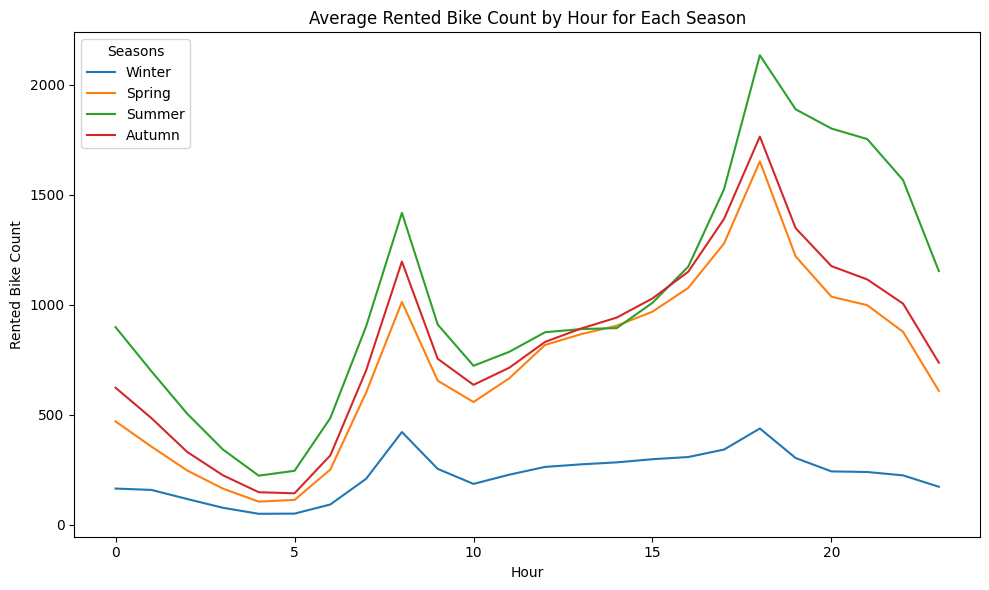

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 30), features: 30
HybridTCNNTransformer: input 30 feats -> d_model=64, heads=4, layers=2, tcnn_channels=64
Epoch 1/100: train 0.2052 | val 0.1654
Epoch 2/100: train 0.0987 | val 0.1010
Epoch 3/100: train 0.0784 | val 0.1112
Epoch 4/100: train 0.0658 | val 0.1147
Epoch 5/100: train 0.0584 | val 0.1027
Epoch 6/100: train 0.0586 | val 0.0568
Epoch 7/100: train 0.0515 | val 0.0670
Epoch 8/100: train 0.0526 | val 0.0521
Epoch 9/100: train 0.0455 | val 0.0808
Epoch 10/100: train 0.0428 | val 0.0711
Epoch 11/100: train 0.0446 | val 0.0503
Epoch 12/100: train 0.0377 | val 0.0576
Epoch 13/100: train 0.0365 | val 0.0732
Epoch 14/100: train 0.0375 | val 0.0473
Epoch 15/100: train 0.0358 | val 0.0465
Epoch 16/100: train 0.0353 | val 0.0544
Epoch 17/100: train 0.0379 | val 0.0614
Epoch 18/100: train 0.0363 | val 0.0513
Epoch 19/100: train 0.0354 | val 0.0536
Epoch 20/100: train 0.0313 | val 0.0539
Epoch 21/100: train 0.

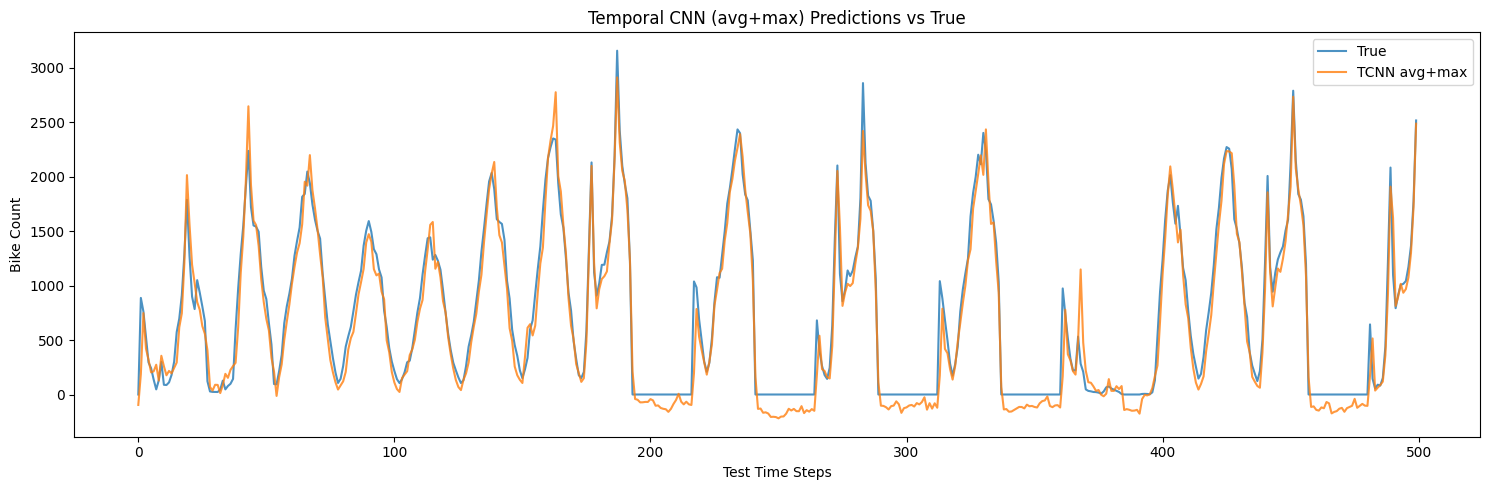

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning like PPT: convert Date to datetime, etc.[file:1]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (similar to PPT) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots[file:1]
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables[file:1]
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# # ----------------  model ----------------
import math
import torch
import torch.nn as nn

# ---- Positional encoding (same as before) ----
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # [T, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

# ---- Small TCNN branch ----
class SmallTemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, kernel_size=3, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)          # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.bn(x)
        x = self.dropout(x)            # [B, C, T]
        # global pooling
        avg_pool = x.mean(dim=2)       # [B, C]
        max_pool, _ = x.max(dim=2)     # [B, C]
        return torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

# ---- Hybrid Transformer + TCNN ----
class HybridTCNNTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.2,
        tcnn_channels=64
    ):
        super().__init__()
        # Transformer branch
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # TCNN branch
        self.tcnn = SmallTemporalCNN(input_size, channels=tcnn_channels, dropout=dropout)

        # Fusion: concat Transformer last token + TCNN pooled features
        fusion_dim = d_model + 2 * tcnn_channels
        self.fc_out = nn.Linear(fusion_dim, 1)

    def forward(self, x):
        # x: [B, T, F]
        # Transformer path
        x_t = self.input_proj(x)          # [B, T, d_model]
        x_t = self.pos_encoder(x_t)       # [B, T, d_model]
        x_t = self.encoder(x_t)           # [B, T, d_model]
        last_t = x_t[:, -1, :]            # [B, d_model]

        # TCNN path
        tcnn_feats = self.tcnn(x)         # [B, 2 * tcnn_channels]

        # Fusion
        fused = torch.cat([last_t, tcnn_feats], dim=1)  # [B, fusion_dim]
        return self.fc_out(fused)                       # [B, 1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridTCNNTransformer(
    input_size=n_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.2,
    tcnn_channels=64
).to(device)

print(f"HybridTCNNTransformer: input {n_features} feats -> d_model=64, heads=4, layers=2, tcnn_channels=64")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Evaluation on TRAIN set ----------------
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# ---------------- 11. Evaluation on TEST set ----------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 12. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()



addding my tcnn logic to this transofer architecture

top 20 features

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

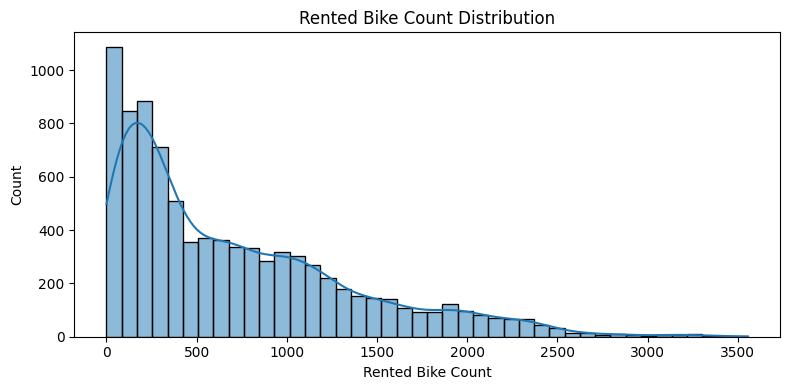

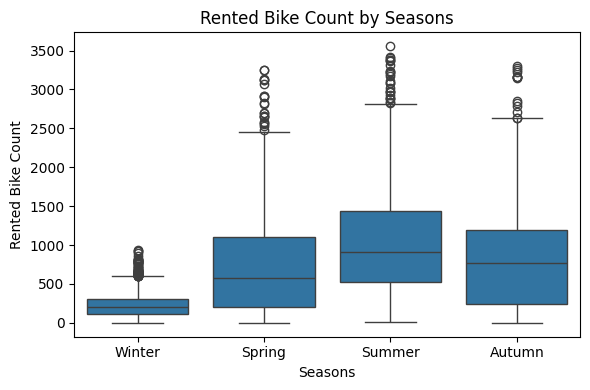

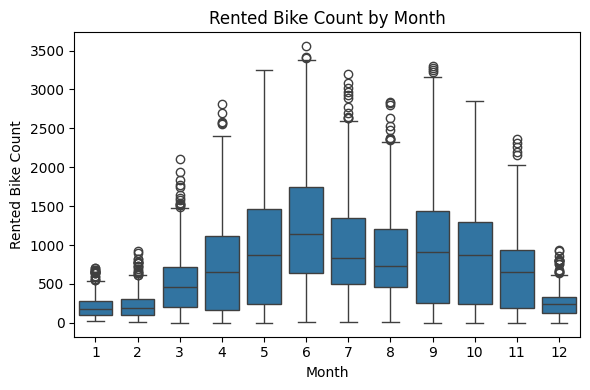

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\2547504914.py:87: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


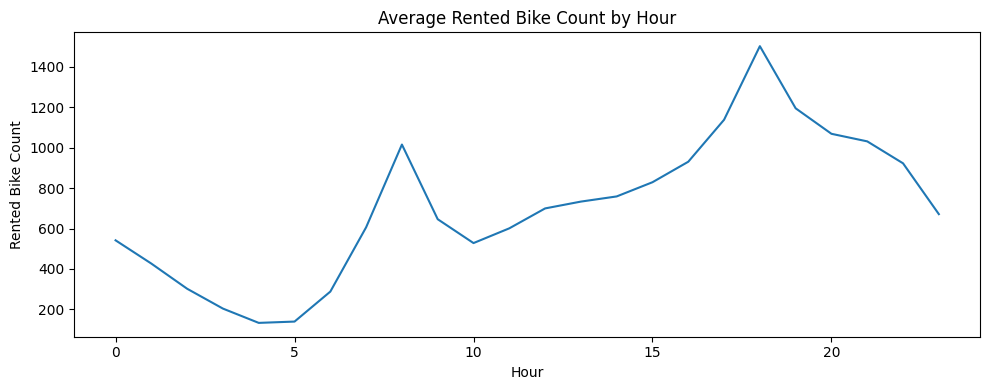

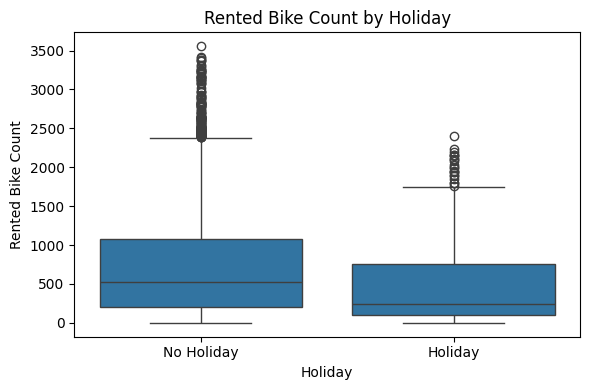

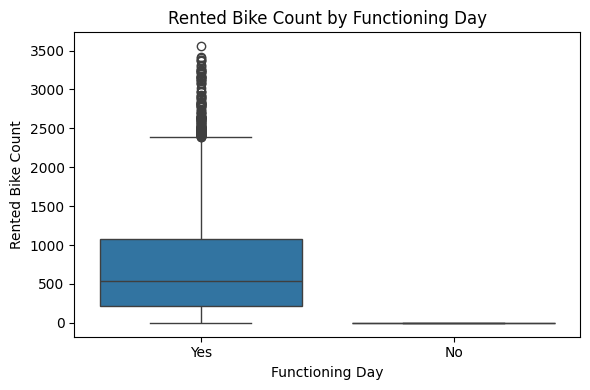

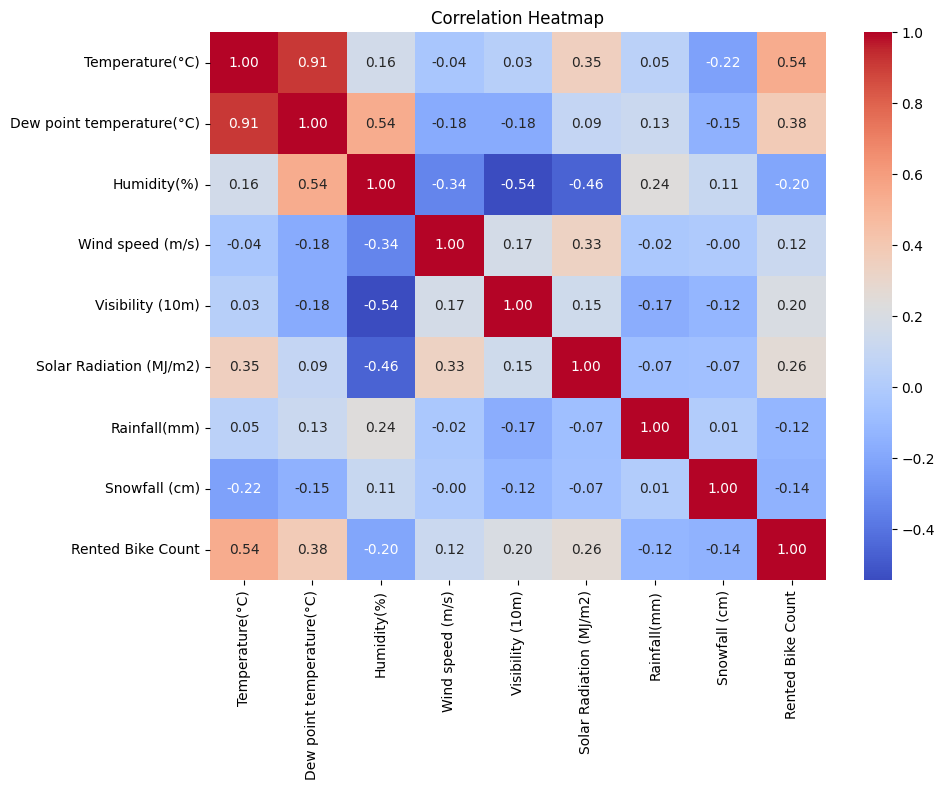

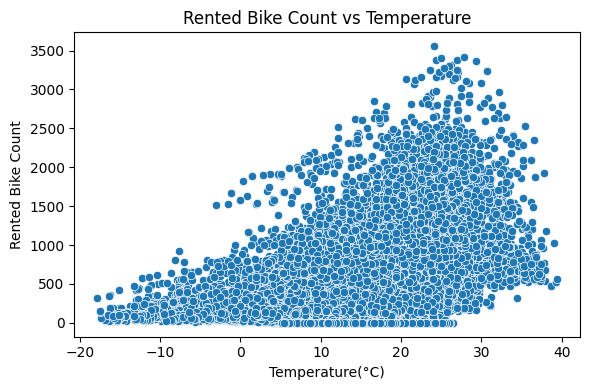

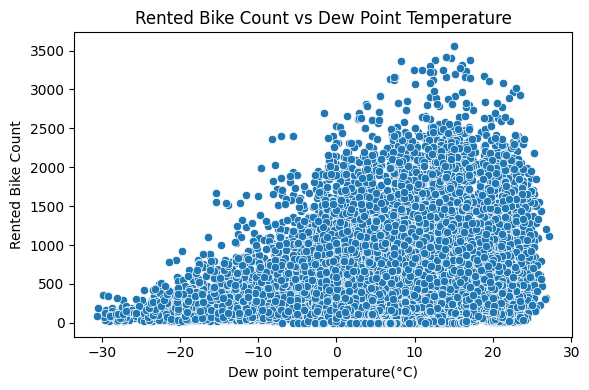

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\2547504914.py:135: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


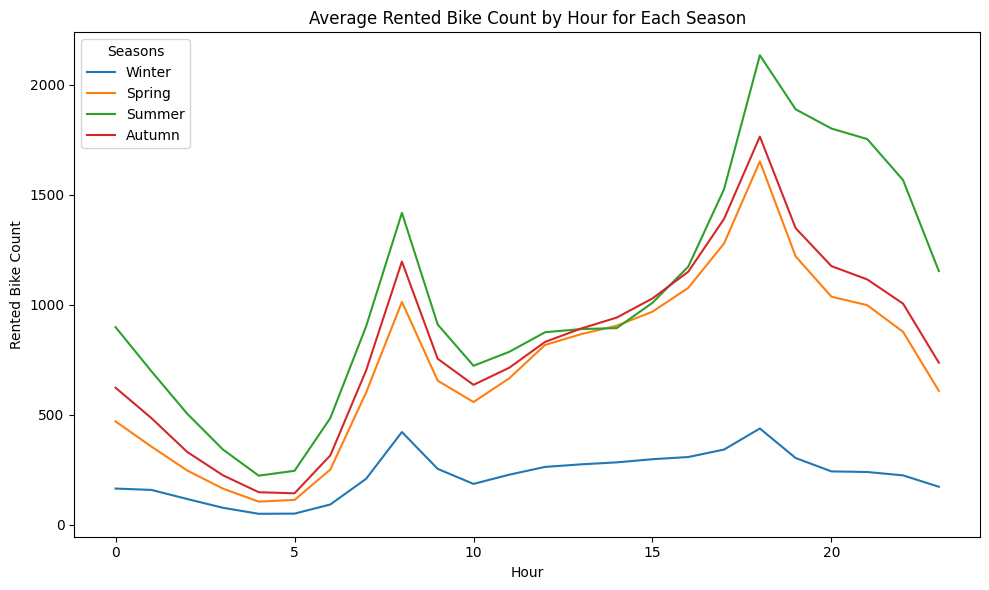

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
HybridTCNNTransformer: input 20 feats -> d_model=64, heads=4, layers=2, tcnn_channels=80
Epoch 1/100: train 0.2344 | val 0.1243
Epoch 2/100: train 0.1038 | val 0.1098
Epoch 3/100: train 0.0746 | val 0.0871
Epoch 4/100: train 0.0707 | val 0.1129
Epoch 5/100: train 0.0658 | val 0.0832
Epoch 6/100: train 0.0600 | val 0.0727
Epoch 7/100: train 0.0538 | val 0.0462
Epoch 8/100: train 0.0457 | val 0.0589
Epoch 9/100: train 0.0447 | val 0.0576
Epoch 10/100: train 0.0410 | val 0.0505
Epoch 11/100: train 0.0402 | val 0.0429
Epoch 12/100: train 0.0491 | val 0.0500
Epoch 13/100: train 0.0435 | val 0.0719
Epoch 14/100: train 0.0396 | val 0.0445
Epoch 15/100: train 0.0348 | val 0.0485
Epoch 16/100: train 0.0342 | val 0.0419
Epoch 17/100: train 0.0365 | val 0.0488
Epoch 18/100: train 0.0379 | val 0.0472
Epoch 19/100: train 0.0336 | val 0.0457
Epoch 20/100: train 0.0308 | val 0.0472
Epoch 21/100: train 0.

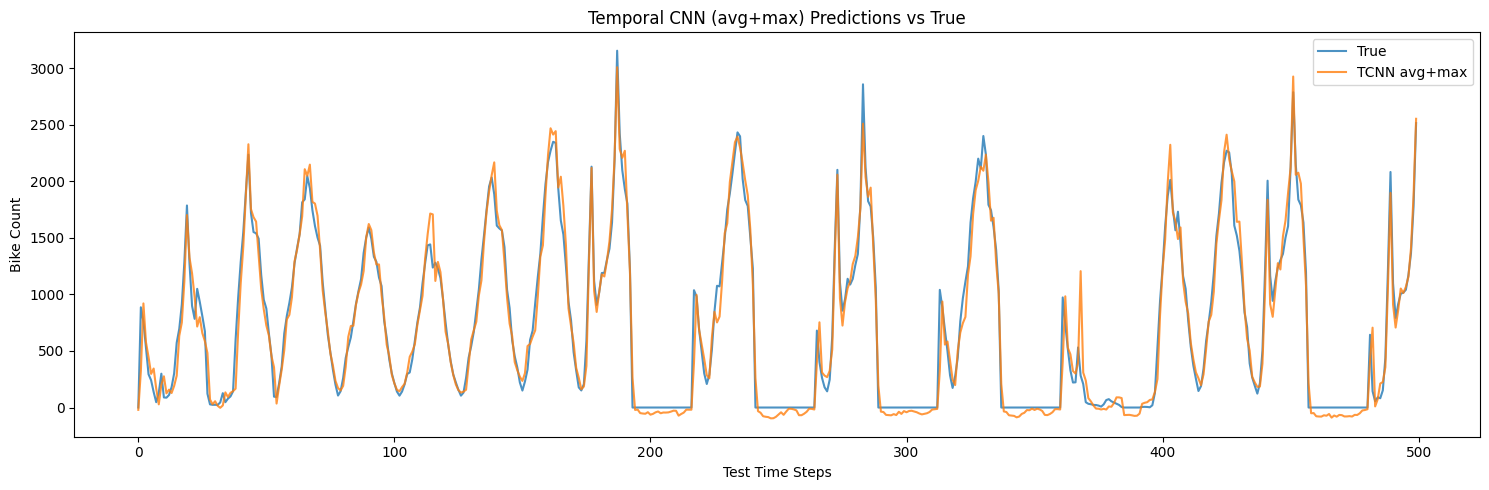

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning like PPT: convert Date to datetime, etc.[file:1]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (similar to PPT) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots[file:1]
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables[file:1]
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# # ----------------  model ----------------
import math
import torch
import torch.nn as nn

# ---- Positional encoding ----
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # [T, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

# ---- Your original TemporalCNN, used as a branch ----
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        # note: output is pooled, so 2*channels features
        # we will NOT use this fc here, just reuse the conv body
        self.fc = nn.Linear(2 * channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)           # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)               # [B, C, T]

        avg_pool = x.mean(dim=2)        # [B, C]
        max_pool, _ = x.max(dim=2)      # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]
        feats = self.dropout(feats)
        return feats                    # [B, 2C]

# ---- Hybrid: Transformer + your TemporalCNN ----
class HybridTCNNTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.2,
        tcnn_channels=80     # must match TemporalCNN channels
    ):
        super().__init__()
        # Transformer branch
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # TemporalCNN branch (your full TCNN)
        self.tcnn = TemporalCNN(input_size=input_size, channels=tcnn_channels, dropout=dropout)

        # Fusion: concat [Transformer_last, TCNN_feats]
        fusion_dim = d_model + 2 * tcnn_channels
        self.fc_out = nn.Linear(fusion_dim, 1)

    def forward(self, x):
        # x: [B, T, F]
        # Transformer path
        x_t = self.input_proj(x)          # [B, T, d_model]
        x_t = self.pos_encoder(x_t)       # [B, T, d_model]
        x_t = self.encoder(x_t)           # [B, T, d_model]
        last_t = x_t[:, -1, :]            # [B, d_model]

        # TCNN path (returns [B, 2 * channels])
        tcnn_feats = self.tcnn(x)         # [B, 2 * tcnn_channels]

        # Fusion
        fused = torch.cat([last_t, tcnn_feats], dim=1)  # [B, fusion_dim]
        return self.fc_out(fused)                       # [B, 1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HybridTCNNTransformer(
    input_size=n_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.2,
    tcnn_channels=80
).to(device)

print(f"HybridTCNNTransformer: input {n_features} feats -> d_model=64, heads=4, layers=2, tcnn_channels=80")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Evaluation on TRAIN set ----------------
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# ---------------- 11. Evaluation on TEST set ----------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 12. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()



top 25 features

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

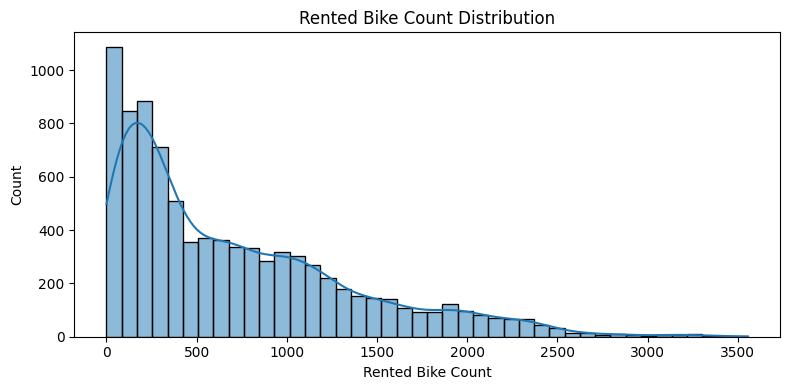

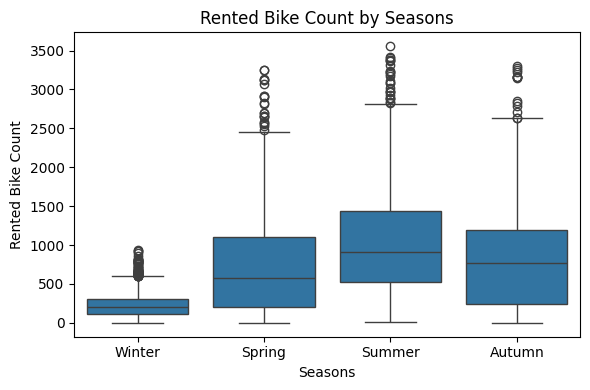

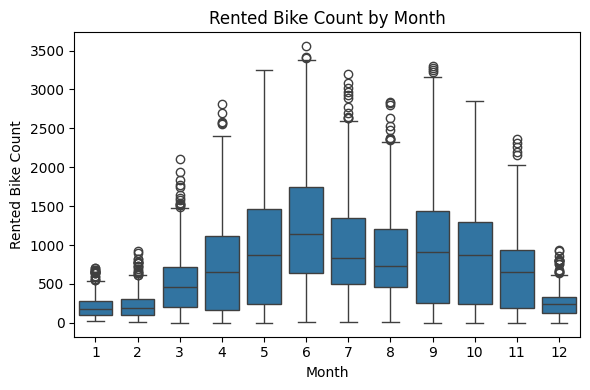

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\1988226059.py:87: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


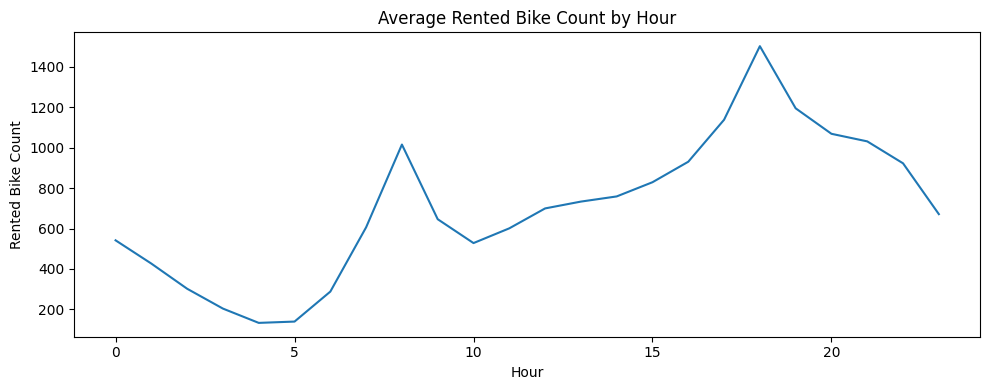

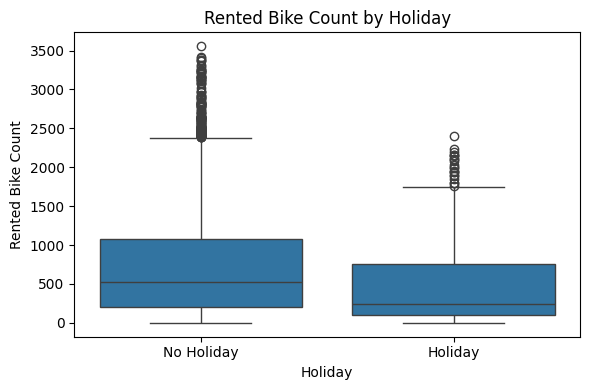

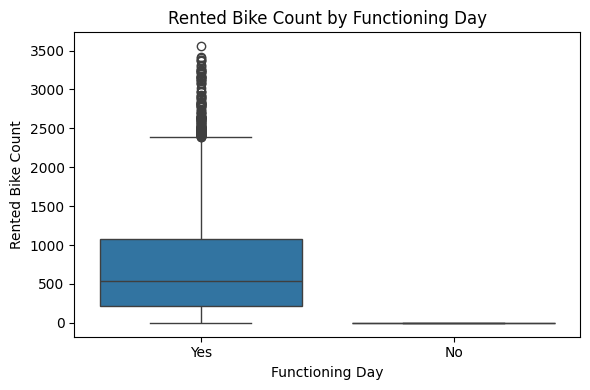

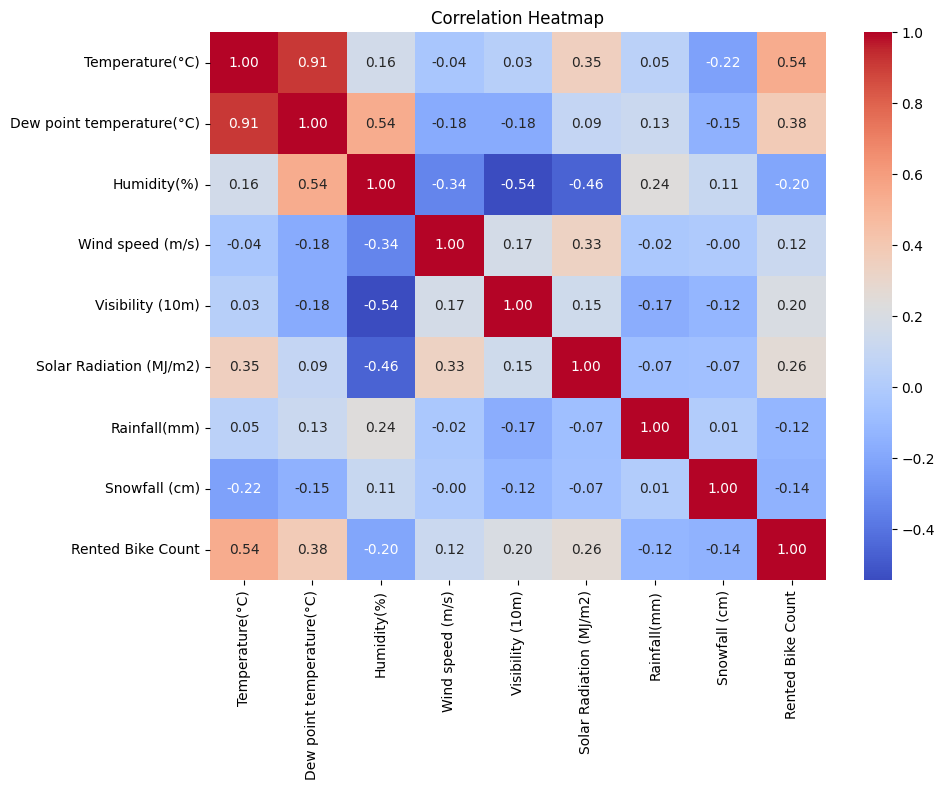

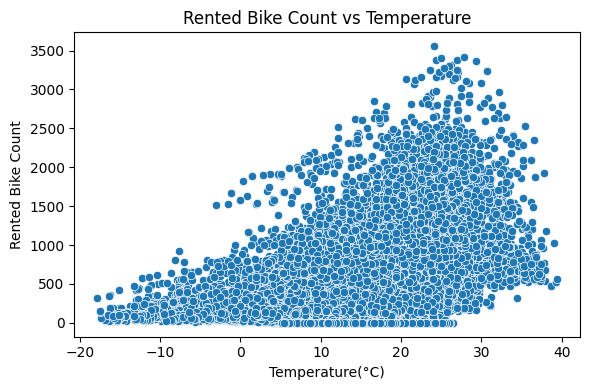

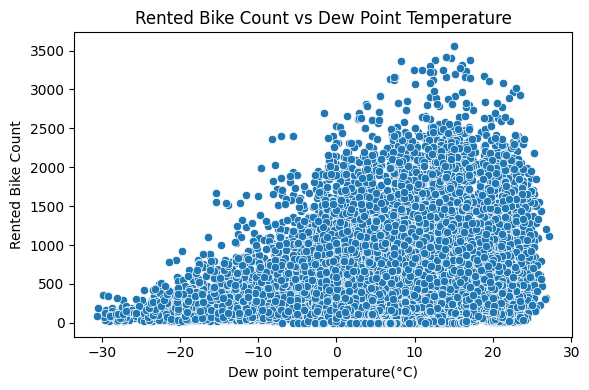

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\1988226059.py:135: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


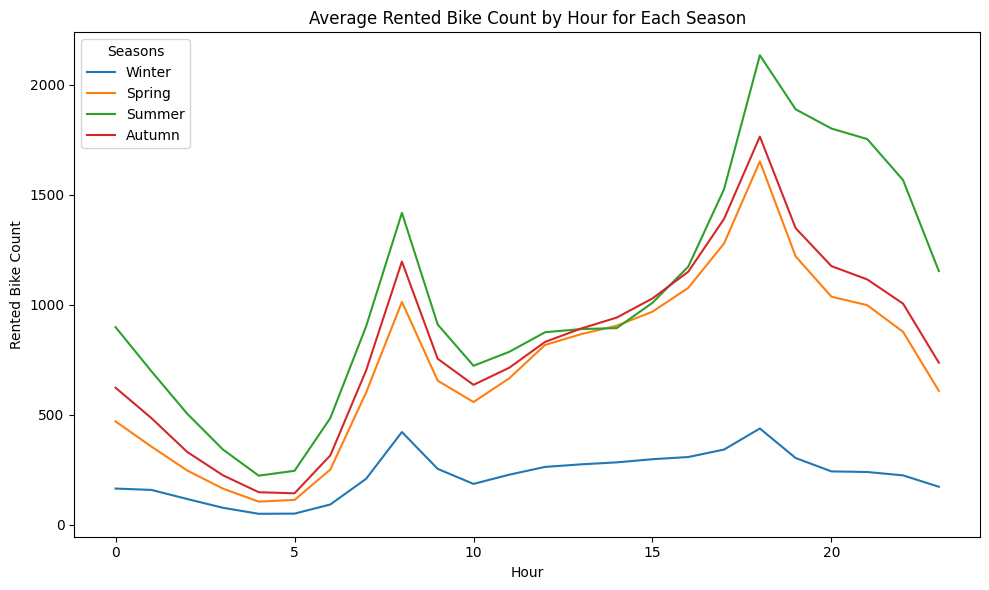

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 25), features: 25
HybridTCNNTransformer: input 25 feats -> d_model=64, heads=4, layers=2, tcnn_channels=80
Epoch 1/100: train 0.2363 | val 0.2271
Epoch 2/100: train 0.1134 | val 0.1142
Epoch 3/100: train 0.0825 | val 0.0994
Epoch 4/100: train 0.0712 | val 0.0806
Epoch 5/100: train 0.0619 | val 0.0918
Epoch 6/100: train 0.0561 | val 0.0832
Epoch 7/100: train 0.0496 | val 0.0748
Epoch 8/100: train 0.0506 | val 0.0723
Epoch 9/100: train 0.0465 | val 0.0651
Epoch 10/100: train 0.0429 | val 0.0567
Epoch 11/100: train 0.0420 | val 0.0697
Epoch 12/100: train 0.0437 | val 0.0511
Epoch 13/100: train 0.0415 | val 0.0567
Epoch 14/100: train 0.0370 | val 0.0516
Epoch 15/100: train 0.0374 | val 0.0610
Epoch 16/100: train 0.0359 | val 0.0581
Epoch 17/100: train 0.0375 | val 0.0600
Epoch 18/100: train 0.0391 | val 0.0517
Epoch 19/100: train 0.0334 | val 0.0458
Epoch 20/100: train 0.0328 | val 0.0474
Epoch 21/100: train 0.

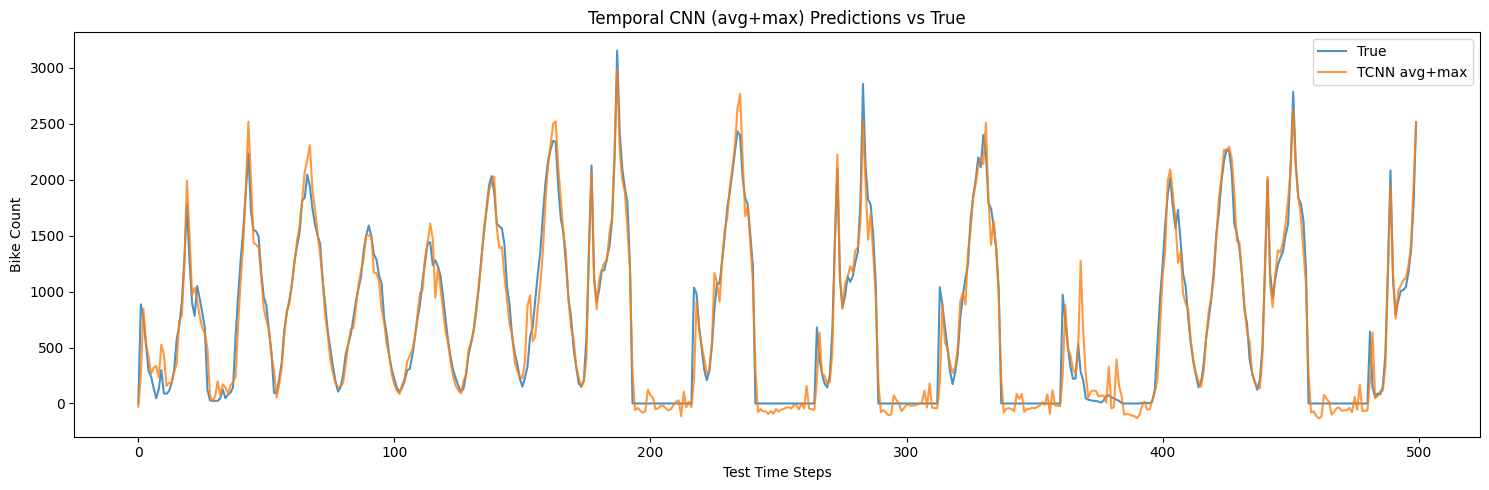

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning like PPT: convert Date to datetime, etc.[file:1]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (similar to PPT) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots[file:1]
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables[file:1]
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 25
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# # ----------------  model ----------------
import math
import torch
import torch.nn as nn

# ---- Positional encoding ----
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # [T, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

# ---- Your original TemporalCNN, used as a branch ----
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        # note: output is pooled, so 2*channels features
        # we will NOT use this fc here, just reuse the conv body
        self.fc = nn.Linear(2 * channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)           # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)               # [B, C, T]

        avg_pool = x.mean(dim=2)        # [B, C]
        max_pool, _ = x.max(dim=2)      # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]
        feats = self.dropout(feats)
        return feats                    # [B, 2C]

# ---- Hybrid: Transformer + your TemporalCNN ----
class HybridTCNNTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.2,
        tcnn_channels=80     # must match TemporalCNN channels
    ):
        super().__init__()
        # Transformer branch
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # TemporalCNN branch (your full TCNN)
        self.tcnn = TemporalCNN(input_size=input_size, channels=tcnn_channels, dropout=dropout)

        # Fusion: concat [Transformer_last, TCNN_feats]
        fusion_dim = d_model + 2 * tcnn_channels
        self.fc_out = nn.Linear(fusion_dim, 1)

    def forward(self, x):
        # x: [B, T, F]
        # Transformer path
        x_t = self.input_proj(x)          # [B, T, d_model]
        x_t = self.pos_encoder(x_t)       # [B, T, d_model]
        x_t = self.encoder(x_t)           # [B, T, d_model]
        last_t = x_t[:, -1, :]            # [B, d_model]

        # TCNN path (returns [B, 2 * channels])
        tcnn_feats = self.tcnn(x)         # [B, 2 * tcnn_channels]

        # Fusion
        fused = torch.cat([last_t, tcnn_feats], dim=1)  # [B, fusion_dim]
        return self.fc_out(fused)                       # [B, 1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HybridTCNNTransformer(
    input_size=n_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.2,
    tcnn_channels=80
).to(device)

print(f"HybridTCNNTransformer: input {n_features} feats -> d_model=64, heads=4, layers=2, tcnn_channels=80")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Evaluation on TRAIN set ----------------
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# ---------------- 11. Evaluation on TEST set ----------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 12. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()



Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

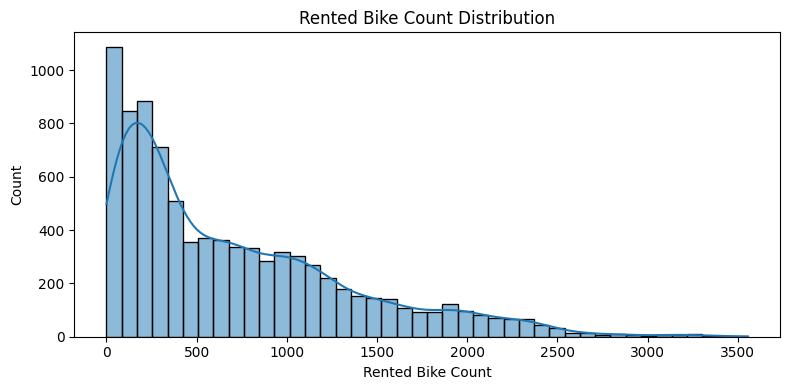

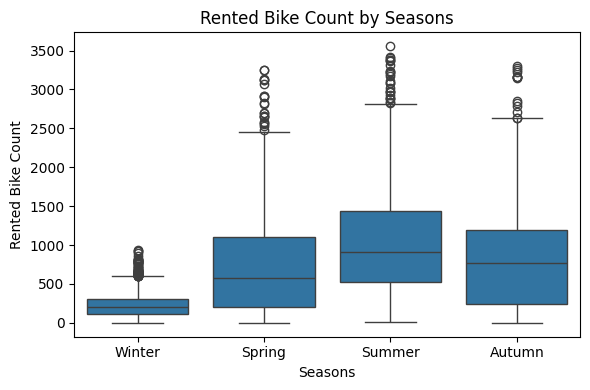

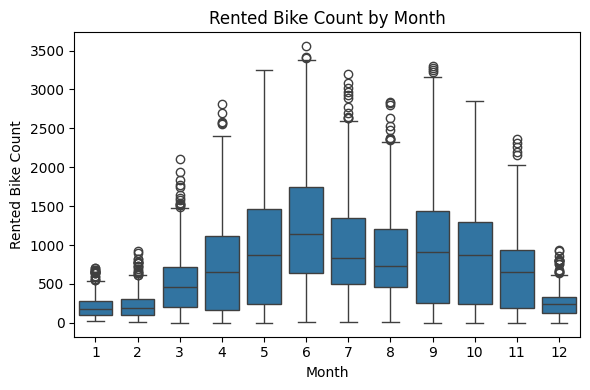

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\153131536.py:87: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


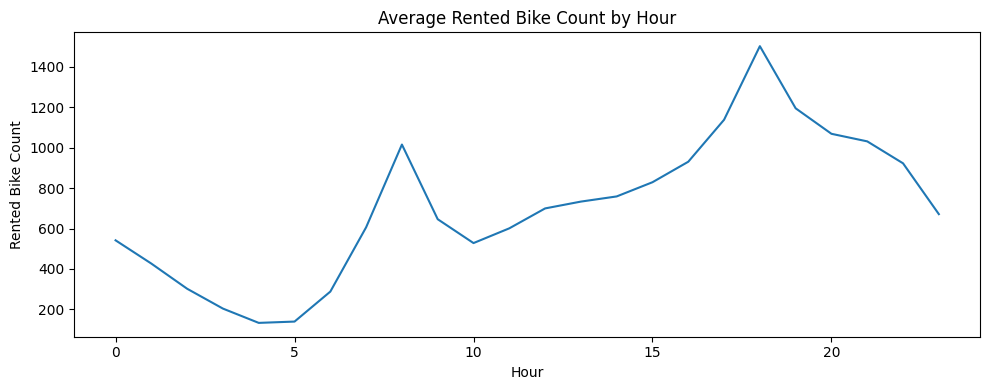

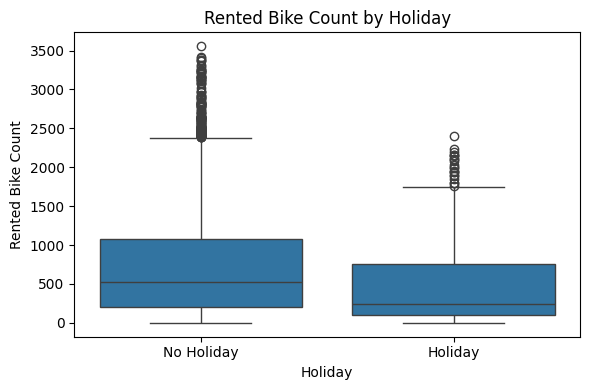

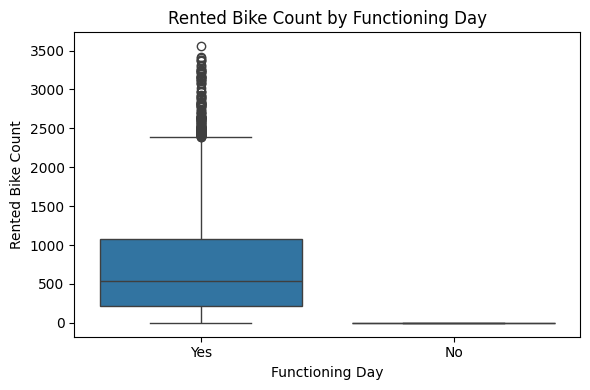

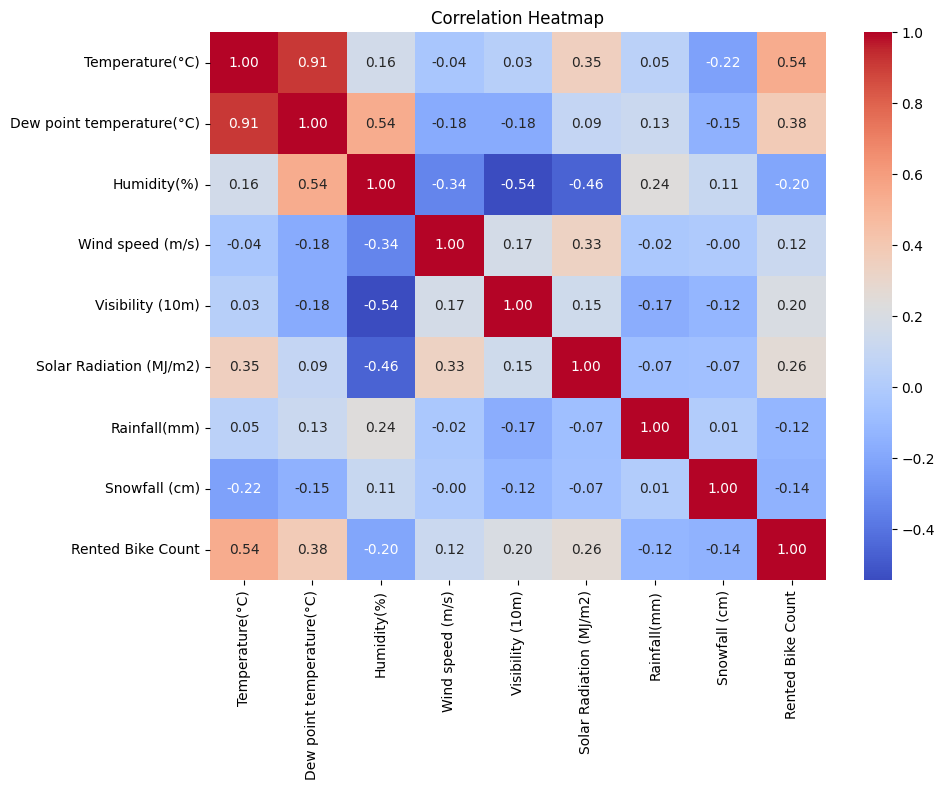

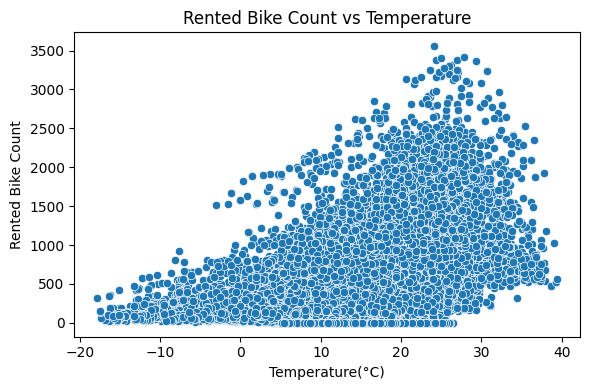

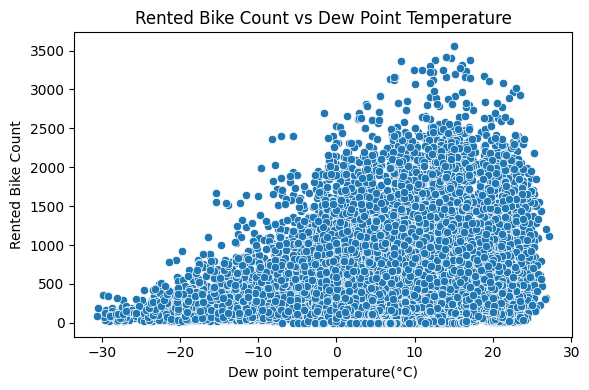

C:\Users\anavn\AppData\Local\Temp\ipykernel_35728\153131536.py:135: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


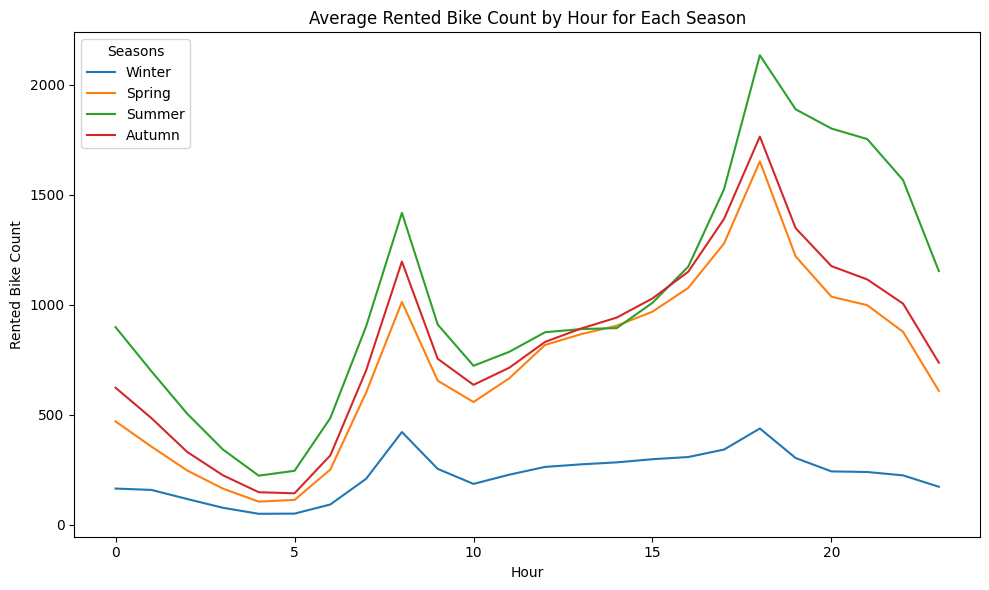

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 30), features: 30
HybridTCNNTransformer: input 30 feats -> d_model=64, heads=4, layers=2, tcnn_channels=80
Epoch 1/100: train 0.2645 | val 0.1476
Epoch 2/100: train 0.1079 | val 0.1571
Epoch 3/100: train 0.0795 | val 0.1250
Epoch 4/100: train 0.0667 | val 0.0707
Epoch 5/100: train 0.0571 | val 0.0955
Epoch 6/100: train 0.0570 | val 0.0982
Epoch 7/100: train 0.0582 | val 0.0720
Epoch 8/100: train 0.0465 | val 0.0709
Epoch 9/100: train 0.0432 | val 0.0542
Epoch 10/100: train 0.0403 | val 0.0608
Epoch 11/100: train 0.0397 | val 0.0533
Epoch 12/100: train 0.0396 | val 0.0836
Epoch 13/100: train 0.0394 | val 0.0595
Epoch 14/100: train 0.0392 | val 0.0538
Epoch 15/100: train 0.0372 | val 0.0513
Epoch 16/100: train 0.0374 | val 0.0578
Epoch 17/100: train 0.0348 | val 0.0682
Epoch 18/100: train 0.0375 | val 0.0627
Epoch 19/100: train 0.0443 | val 0.0886
Epoch 20/100: train 0.0405 | val 0.0583
Epoch 21/100: train 0.

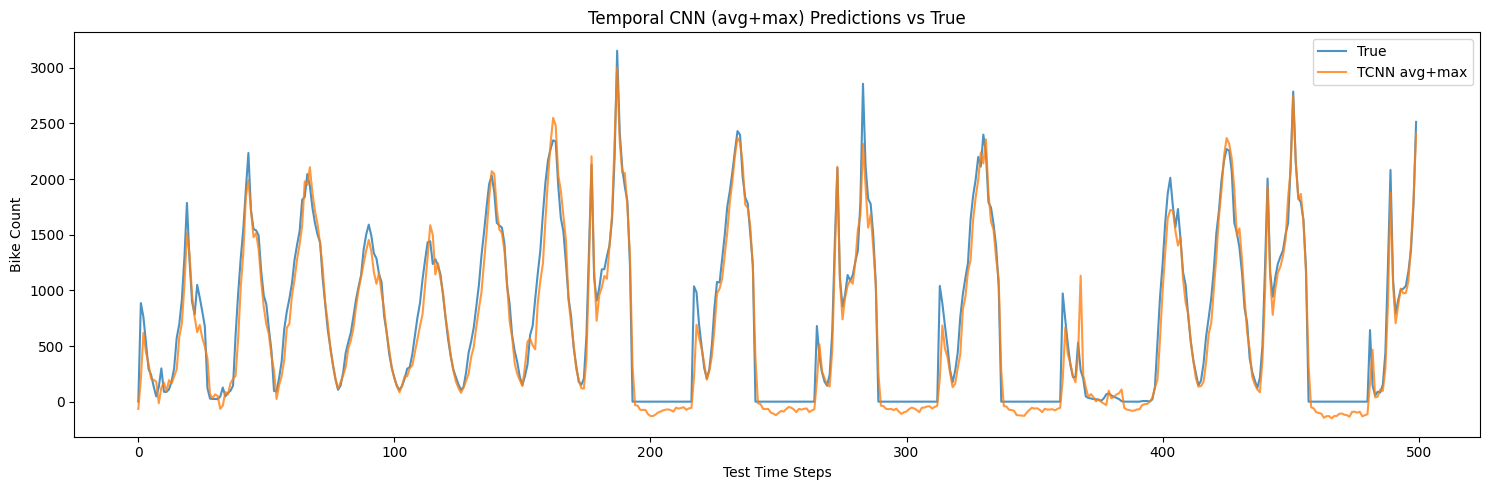

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning like PPT: convert Date to datetime, etc.[file:1]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (similar to PPT) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots[file:1]
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables[file:1]
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# # ----------------  model ----------------
import math
import torch
import torch.nn as nn

# ---- Positional encoding ----
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)          # [T, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                        # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

# ---- Your original TemporalCNN, used as a branch ----
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        # note: output is pooled, so 2*channels features
        # we will NOT use this fc here, just reuse the conv body
        self.fc = nn.Linear(2 * channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)           # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)               # [B, C, T]

        avg_pool = x.mean(dim=2)        # [B, C]
        max_pool, _ = x.max(dim=2)      # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]
        feats = self.dropout(feats)
        return feats                    # [B, 2C]

# ---- Hybrid: Transformer + your TemporalCNN ----
class HybridTCNNTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.2,
        tcnn_channels=80     # must match TemporalCNN channels
    ):
        super().__init__()
        # Transformer branch
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # TemporalCNN branch (your full TCNN)
        self.tcnn = TemporalCNN(input_size=input_size, channels=tcnn_channels, dropout=dropout)

        # Fusion: concat [Transformer_last, TCNN_feats]
        fusion_dim = d_model + 2 * tcnn_channels
        self.fc_out = nn.Linear(fusion_dim, 1)

    def forward(self, x):
        # x: [B, T, F]
        # Transformer path
        x_t = self.input_proj(x)          # [B, T, d_model]
        x_t = self.pos_encoder(x_t)       # [B, T, d_model]
        x_t = self.encoder(x_t)           # [B, T, d_model]
        last_t = x_t[:, -1, :]            # [B, d_model]

        # TCNN path (returns [B, 2 * channels])
        tcnn_feats = self.tcnn(x)         # [B, 2 * tcnn_channels]

        # Fusion
        fused = torch.cat([last_t, tcnn_feats], dim=1)  # [B, fusion_dim]
        return self.fc_out(fused)                       # [B, 1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HybridTCNNTransformer(
    input_size=n_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.2,
    tcnn_channels=80
).to(device)

print(f"HybridTCNNTransformer: input {n_features} feats -> d_model=64, heads=4, layers=2, tcnn_channels=80")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Evaluation on TRAIN set ----------------
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# ---------------- 11. Evaluation on TEST set ----------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 12. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

